# Анализ удовлетворенности клиентов. Исследование комфорта при работе климатического оборудования.

## Описание проекта

### Поставленная задача

Проанализировать полученные данные и предоставить выводы о том, в какой тип климатического оборудования стоит инвестировать больше, чтобы повысить удовлетворенность клиентов созданными условиями в зависимости от региона? И на что стоит обратить внимание при развитии бизнеса в разных регионах?

### Описание данных

**Год** - Год проведения исследования<br>
**Время года** - Весна, лето, осень, зима<br>
**Климат** - Название типа климата<br> 
**Город** - Город, где было проведено исследование<br> 
**Страна** - Страна, где было проведено исследование<br>
**Способ охлаждения**:<br>
- **Кондиционирование** = может быть разных типов, окна закрыты.
- **Вентиляция** = механические системы вентиляции и естественное охлаждение.
- **Смешанный** = механическое охлаждение, окна могут быть как открыты, так и закрыты.
- **NA** = не применимо, например исследование холодной зимой, когда включено отопление.
  
**Режим при смешанном типе охлаждения**:<br>
- **NA** = здания, не относящиеся к смешанному типу.
- **Кондиционер** = кондиционер включен, окна закрыты.
- **Вентиляция** = кондиционер выключен, окна открыты/механическая
	вентиляция.

**Способ обогрева**:
- **Механическое отопление** = в здании имеется механическая система отопления (переносные обогреватели не считаются механическим отоплением на уровне здания).
- **NA** = отсутствие механического отопления, неизвестно или исследование только в жаркую летнюю погоду.
  
**Возраст** - Возраст респондента<br>
**Пол** - Пол респондента<br> 
**Ощущение температуры** - Оценка температуры по ощущениям: от -3 (холодно) до +3 (горячо)<br>
**Ощущение температуры (bool)** - 0 = неприемлемо, 1 = приемлемо<br> 
**Предпочтительное изменение температуры** - Без изменений, теплее, холоднее<br> 
**Ощущение движения воздуха (bool)** - 0 = неприемлемо, 1 = приемлемо <br>
**Предпочтительное изменение движения воздуха** - Меньше, без изменений, больше<br> 
**Оценка комфорта** - От 1 (очень неудобно) до 6 (очень комфортно) <br>
**Утепление** - Фактор связанный с одеждой респондента<br> 
**Температура воздуха в помещении** - Измеренная температура в помещении<br> 
**Температура воздуха на улице** - Измеренная температура на улице <br>
**RH** - Относительная влажность <br>
**Скорость воздуха** - Скорость воздуха, м/с<br> 
**Рост** - Рост респондента<br>
**Вес** - Вес респондента <br>
**Занавески** - 0 = открыто, 1 = закрыто; если неизвестно - нет данных <br>
**Вентилятор** - Режим вентилятора: 0 = выключен, 1 = включен; если неизвестно - нет данных<br> 
**Окно** - 0 = открыто, 1 = закрыто; если неизвестно - нет данных <br>
**Двери** - 0 = открыты, 1 = закрыты; если неизвестно - нет данных<br>
**Отопление** - Режим обогрева: 0 -выключен, 1 - включен; если неизвестно - нет данных<br> 
**Среднемесячная температура на улице** - Среднемесячная температура наружного воздуха на момент исследования, C.<br>
**Количество рекламаций** - Количество жалоб на установленное оборудование, полученных от клиента, за прошедший период<br>

## Imports

### Скачивание библиотек

In [1086]:
pip install pandas

Note: you may need to restart the kernel to use updated packages.


In [1087]:
pip install numpy

Note: you may need to restart the kernel to use updated packages.


In [1088]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [1089]:
pip install scipy

Note: you may need to restart the kernel to use updated packages.


In [1090]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [1092]:
pip install -U scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [1093]:
pip install statsmodels

Note: you may need to restart the kernel to use updated packages.


### Подключение библиотек

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency, pearsonr, spearmanr, mannwhitneyu, ttest_ind, shapiro, kruskal, f_oneway
from statsmodels.stats.multitest import multipletests
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from itertools import combinations

## Path

In [20]:
MAIN_TABLE = 'data.csv'

## User functions

In [21]:
class SeparatorError(Exception):
    """Пользовательское исключение для ошибки разделителя в CSV файле."""
    pass


def read_file(PATH):
    """
    Чтение файла CSV с автоматическим определением параметров и форматированием названий столбцов.

    Функция пытается прочитать CSV-файл, автоматически определяя кодировку и разделитель.
    Приводит названия столбцов к формату PEP8 (нижний регистр, подчеркивание вместо пробелов).

    Аргументы:
        PATH (str): Путь к файлу для чтения.

    Возращает:
        pd.DataFrame: 
            - Успешное чтение: DataFrame с данными
            - Ошибка: DataFrame с одной колонкой 'error', содержащей тип ошибки:
                * 'encoding' - проблемы с кодировкой
                * 'separator' - проблемы с разделителем
                * 'file_path' - файл не найден
    """
    encodes = ['utf-8', 'cp1251']
    separators = [';', ',']
    dcml = '.'
    data = pd.DataFrame()
    for encode in encodes:
        for separator in separators:
            try:
                data = pd.read_csv(PATH, sep=separator, encoding=encode, decimal=dcml)
                data.columns = data.columns.str.lower().str.replace(' ', '_')
                if len(data.columns) == 1:
                    raise SeparatorError
                return data
            except UnicodeError:
                data = pd.DataFrame({'error': ['encoding']})
            except SeparatorError:
                data = pd.DataFrame({'error': ['separator']})
            except FileNotFoundError:
                data = pd.DataFrame({'error': ['file_path']})
    return data

In [22]:
def change_types(data, columns):
    """
    Изменяет типы данных указанных столбцов в DataFrame с обработкой ошибок.

    Функция последовательно преобразует типы данных столбцов согласно переданному
    словарю соответствий. Предусмотрена обработка ошибок преобразования типов.

    Аргументы:
        data (pd.DataFrame): Исходный DataFrame для преобразования
        columns (dict): Словарь преобразований формата:
            {
                'название_столбца': тип_данных,
                ...
            }
            Поддерживаемые типы: int, float, str, 'category', bool, datetime64 и др.

    Возращает:
        None: Изменения применяются непосредственно к переданному DataFrame (inplace)
    """
    for key, val in columns.items():
        try:
            data[key] = data[key].astype(val)
        except ValueError:
            print('Ошибка при изменении типа данных в столбце с именем ', key)
        except KeyError:
            print('Возможно было неправильно указано название столбца', key)

In [23]:
def unique_values(data, columns):
    """
    Выводит уникальные значения для указанных столбцов DataFrame в читаемом формате.

    Функция анализирует и отображает все уникальные значения для каждого указанного столбца,
    разделяя результаты визуальными маркерами для удобства чтения.

    Args:
        data (pd.DataFrame): Исходный DataFrame для анализа
        columns (list): Список названий столбцов, для которых нужно показать уникальные значения

    Returns:
        None: Результаты выводятся в консоль
    """
    print('###########')
    print(*['\n###########\n'.join([column, '\n'.join(data[column].unique())]) for column in columns], sep='\n\n###########\n')

In [24]:
def correlation_ratio(categories, values):
    """
    Вычисляет корреляционное отношение (η) между категориальной и количественной переменными.

    Корреляционное отношение (Eta coefficient) измеряет степень связи между номинальной
    и интервальной переменными. Значение варьируется от 0 (отсутствие связи) до 1 (полная зависимость).

    Аргументы:
        categories (array-like или pd.Series): Категориальная переменная (группирующая)
        values (array-like или pd.Series): Количественная переменная (непрерывная)

    Возвращает:
        float: Значение корреляционного отношения η в диапазоне [0, 1] или np.nan,
              если вычисление невозможно
    """
    categories = np.array(categories)
    values = np.array(values)    
    ssw = 0
    ssb = 0
    for category in set(categories):
        subgroup = values[np.where(categories == category)[0]]
        ssw += sum((subgroup - np.mean(subgroup)) ** 2)
        ssb += len(subgroup) * (np.mean(subgroup) - np.mean(values)) ** 2
    if ssb + ssw == 0:
        return np.nan
    return round((ssb / (ssb + ssw)) ** 0.5, 4)

In [25]:
def my_cramers(x, y):
    """
    Вычисляет коэффициент корреляции Крамера между двумя категориальными переменными.

    Коэффициент Крамера (V) измеряет силу связи между двумя номинальными переменными.
    Значение варьируется от 0 (нет связи) до 1 (полная зависимость). Используется
    как мера ассоциации для таблиц сопряженности любого размера.

    Аргументы:
        x (pd.Series или array-like): Первая категориальная переменная
        y (pd.Series или array-like): Вторая категориальная переменная

    Возвращает:
        float: Значение коэффициента Крамера V в диапазоне [0, 1]
    """
    data = pd.crosstab(x, y)
    n = data.sum().sum()
    theory = np.outer(data.values.sum(axis=1),
                      data.values.sum(axis=0)) / n
    chi2 = ((data.values - theory) ** 2 / theory).sum()
    chi2 = chi2_contingency(data)[0]
    r, c = data.values.shape
    if min(r - 1, c - 1) == 0:
        cramer = 0
    else:
        cramer = np.sqrt(chi2 / (n * min(r - 1, c - 1)))
    return round(cramer, 4)

In [26]:
# columns - список названий столбцов, по которым будем строить ящик с усами.

def boxplot_chart(data, columns):
    """
    Строит диаграммы "ящик с усами" (boxplot) для указанных числовых столбцов.

    Функция создает отдельные boxplot-диаграммы для каждого указанного столбца,
    что позволяет визуально оценить распределение данных, выявить выбросы и сравнить
    основные статистические характеристики.

    Аргументы:
        data (pd.DataFrame): Исходный датафрейм с данными для визуализации
        columns (list): Список названий числовых столбцов для анализа

    Возвращает:
        None: Функция выводит графики через matplotlib.pyplot.show()
    """
    for column in columns:
        sns.boxplot(data, y=column)
        plt.title(f'График ящик с усами для столбца {column}', loc='center')
        plt.show()       

In [27]:
def addnew_col_for_pie(data, new_col, col, val0, val1, valnan):
    """
    Создает новый категориальный столбец на основе булевых значений с возможностью кастомизации.

    Функция преобразует булевы/бинарные значения в произвольные категориальные метки,
    что особенно полезно для подготовки данных к визуализации (например, для круговых диаграмм).

    Аргументы:
        data (pd.DataFrame): Исходный датафрейм для преобразования
        new_col (str): Название создаваемого столбца
        col (str): Название исходного столбца с бинарными данными (0/1)
        val0 (any): Значение для замены 0 (False)
        val1 (any): Значение для замены 1 (True)
        valnan (any): Значение для замены NaN (пропущенных значений)

    Возвращает:
        None: Исходный датафрейм с добавленным новым столбцом (изменения происходят inplace)
    """
    data[new_col] = data[col].replace({0: val0, 1: val1, np.nan: valnan})

In [28]:
# напишем функцию первичной проверки данных
def check_data(data):
    """
    Проводит комплексный первичный анализ данных с визуализацией.

    Функция выполняет:
    - Анализ структуры данных
    - Проверку на пропущенные значения
    - Поиск дубликатов
    - Описательную статистику
    - Визуализацию распределений

    Аргументы:
        data (pd.DataFrame): Анализируемый датафрейм. Может содержать как количественные,
                            так и категориальные переменные.

    Возвращает:
        None: Функция выводит результаты анализа в виде:
            - Текстовых сводок
            - Таблиц
            - Графиков
    """
    print('\033[1m' + 'Изучим исходные данные' + '\033[0m')
    print(data.info())
    # проверим nan
    print('\033[1m' + '\nПроверка пропусков' + '\033[0m')
    print('Количество пропусков:\n{:.0f}'.format(data.isnull().sum().sum()))
    print('Доля пропусков:\n{}'.format(data.isna().mean().round(4)))
    plt.figure(figsize=(10, 6))
    sns.heatmap(data.isna().T)
    plt.suptitle('Оценка пропусков на heatmap')
    plt.show()
    print()
    # проверим дубликаты
    print('\033[1m' + '\nПроверка на дубликаты' + '\033[0m')
    print('Количество полных дубликатов:\n', data.duplicated().sum())
    # посмотрим на сами данные
    print('\033[1m' + '\nПервые 10 строк датасета' + '\033[0m')
    display(data.head(10))
    print('\033[1m' + '\nОписание количественных данных:' + '\033[0m')
    display(data.describe(exclude=['object']).T)
    print('\033[1m' + '\nГрафическое представление количественных данных:' + '\033[0m')
    for numeric_column in data.select_dtypes(exclude=['object', 'category']).columns:
        sns.histplot(data[numeric_column])
        plt.suptitle(f'Гистограмма распределения ({numeric_column})')
        plt.show()
        print()
    print('\033[1m' + '\nОписание категориальных данных:' + '\033[0m')
    display(data.describe(include=['object']).T)
    print('\033[1m' + '\nГрафическое представление категориальных данных:' + '\033[0m')
    for category in data.select_dtypes(include=['object']).columns:
        table = data[category].value_counts()
        plt.pie(table, labels=table.index, autopct='%1.1f%%')
        title = category.rstrip('_кат')
        plt.suptitle(f'Круговая диаграмма распределения {title}')
        plt.show()

In [29]:
def conclusion(stat, p, method):
    """
    Формирует интерпретацию результатов статистического теста для отчета.

    Функция анализирует результаты статистического теста и формирует понятный вывод
    о наличии/отсутствии статистически значимых различий между группами с визуальными
    индикаторами результата.

    Аргументы:
        stat (float): Значение статистики теста (t-критерий, U-критерий и т.д.)
        p (float): Полученное p-значение (уровень значимости)
        method (str): Название использованного статистического метода

    Возвращает:
        str: Готовый вывод с интерпретацией результатов в формате:
            "Метод: [название метода], stat: [значение], p-value: [значение], [вывод]"
    """
    if p < 0.05:
        return f"Метод: {method}, stat: {round(stat, 4)}, p-value: {round(p, 4)}, ✅ Различия в оценке комфорта между группами статистически значимы."
    else:
        return f"Метод: {method}, stat: {round(stat, 4)}, p-value: {round(p, 4)}, 🚫 Различий в комфорте между группами не выявлено."

In [30]:
def pairwise_comparison_mannwhitn(groupby, col):
    """
    Выполняет попарное сравнение групп с помощью U-критерия Манна-Уитни.

    Функция проводит попарное сравнение независимых выборок для категориально-количественных
    данных с ненормальным распределением. Используется для сравнения медиан между группами.

    Аргументы:
        groupby (str): Название категориального столбца, по которому производится группировка.
                      Определяет группы для сравнения.
        col (str): Название количественного столбца с измеряемыми значениями для сравнения.

    Возвращает:
        tuple: Кортеж, содержащий:
            - pvals (list): Список p-значений для каждой пары сравнений
            - comparisons (list): Список строк с описанием сравниваемых пар групп
              в формате "группа1 vs группа2"
    """
    df2 = df[[groupby, col]].dropna()
    groups = df2.groupby(groupby)[col].apply(list)
    group_names = groups.index.tolist()
    group_data = [groups[name] for name in group_names]

    pvals = []
    comparisons = []
    
    for i in range(len(group_data)):
        for j in range(i + 1, len(group_data)):
            u_stat, p = mannwhitneyu(group_data[i], group_data[j], alternative='two-sided')
            pvals.append(round(p, 4))
            comparisons.append(f"{group_names[i]} vs {group_names[j]}")
    return pvals, comparisons

In [31]:
def testing_statistical_hypotheses(df, columns, values=None):
    '''
    Функция автоматически выбирает подходящий статистический тест на основе:
    - Количества групп (2 или более)
    - Нормальности распределения (тест Шапиро-Уилка)
    
    Для двух групп выбирает между t-тестом Стьюдента или тестом Манна-Уитни.
    Для нескольких групп выбирает между ANOVA или тестом Краскела-Уоллиса.

    Аргументы:
        df (pandas.DataFrame): Входной DataFrame с данными для анализа.
        columns (list): Список названий столбцов, где:
            - Первый элемент - категориальная переменная для группировки
            - Второй элемент - количественная переменная для сравнения
        values (list, optional): Для бинарных сравнений указывает, какие два значения
            группирующей переменной сравнивать. По умолчанию None.

    Возвращает:
        tuple: Кортеж содержащий:
            - stat (float): Рассчитанная статистика теста
            - p (float): p-значение теста
            - method (str): Название использованного статистического теста
    '''
    
    levels = df[columns[0]].dropna().unique()
    if len(levels) > 2:
        groups = [group['оценка_комфорта'].dropna().values for name, group in df.groupby('способ_охлаждения')]
        
        if len(set([shapiro(i) for i in groups])) == 1:
            method = 'ANOVA'
            stat, p = f_oneway(*groups)
        else:
            method = 'Краскела–Уоллиса'
            stat, p = kruskal(*groups)
        return round(stat, 4), round(p, 4), method
    else:
        df2 = df[[*columns]].dropna()

        sample_1 = df2[df2[columns[0]] == values[0]][columns[1]]
        sample_2 = df2[df2[columns[0]] == values[1]][columns[1]]

        if shapiro(sample_1)[1] >= 0.05 and shapiro(sample_2)[1] >= 0.05:
            method = 'Стьюдент'
            stat, p = ttest_ind(sample_1, sample_2, equal_var=False)
        else:
            method = 'Манн-Уитни'
            stat, p = mannwhitneyu(sample_1, sample_2, alternative='two-sided')
            
        return round(stat, 4), round(p, 4), method
        
    return np.nan, np.nan

In [32]:
def analize(df, cnt):
    """
    Проводит анализ оценки комфорта по категориям влажности для указанной страны.

    Функция выполняет:
    1. Фильтрацию данных по указанной стране
    2. Проверку нормальности распределения оценок комфорта для каждой категории влажности
    3. Непараметрический статистический тест (Краскела-Уоллиса) для сравнения групп

    Аргументы:
        df (pd.DataFrame): Исходный DataFrame с колонками:
            - 'страна': категориальная переменная с названиями стран
            - 'категория_влажности': категориальная переменная с группами влажности
            - 'оценка_комфорта': количественная переменная с оценками комфорта
        cnt (str): Название страны для анализа

    Возращает:
        None: Результаты выводятся в консоль
    """
    print('Страна:', cnt)
    dt = df[df['страна'] == cnt]
    gr = []
    # Группируем по категориям влажности
    for cat in dt['категория_влажности'].unique():
        gr.append([cat, dt[dt['категория_влажности'] == cat]['оценка_комфорта'].dropna()])
    # Проверка на нормальность
    for nm, v in gr:
        _, pv = shapiro(v)
        print(nm, '- Shapiro', 'p =', round(pv, 4))
    # Данные не распределнны нормально так что используем Краскела Уолеса
    _, p = kruskal(*[i[1] for i in gr])
    print('Краскела Уолеса p =', round(p, 4))

In [33]:
def kolvo_complaints_cat(kolvo):
    """
    Классифицирует количество жалоб на категории 'мало', 'средне', 'много'.

    Функция принимает количество жалоб и возвращает соответствующую текстовую категорию
    согласно заданным критериям классификации.

    Аргументы:
        kolvo (int): Количество жалоб для классификации. Должно быть целым неотрицательным числом.

    Возращает:
        str: Категория количества жалоб:
            - 'мало' - если 0 или 1 жалоба
            - 'средне' - если 2 жалобы
            - 'много' - если 3 и более жалоб
    """
    if kolvo <= 1:
        return 'мало'
    elif kolvo == 2:
        return 'средне'
    return 'много'

In [34]:
def age_category(age):
    """
    Классифицирует возраст человека по категориям: молодой, средний, пожилой.

    Функция принимает возраст в годах и возвращает соответствующую возрастную категорию
    согласно стандартной медицинской классификации.

    Args:
        age (int): Возраст в годах. Должен быть положительным числом.

    Returns:
        str: Возрастная категория:
            - 'молодой возраст' - от 0 до 44 лет включительно
            - 'средний возраст' - от 45 до 59 лет включительно
            - 'пожилой возраст' - 60 лет и старше
    """
    if age <= 44:
        return 'молодой возраст'
    elif 45 <= age <= 59:
        return 'средний возраст' 
    return 'пожилой возраст'

In [35]:
""" Согласно международным рекомендациям:
ASHRAE (Американское общество инженеров по отоплению, охлаждению и кондиционированию воздуха):
Рекомендуемая относительная влажность в помещениях (включая офисы) — от 30% до 60%.
Комфортный диапазон — 40–60%. """

def cat_hum(rh):
    """
    Классифицирует уровень относительной влажности воздуха согласно стандартам ASHRAE.

    Функция определяет категорию влажности на основе рекомендаций Американского общества
    инженеров по отоплению, охлаждению и кондиционированию воздуха (ASHRAE).

    Aргументы:
        rh (float): Значение относительной влажности в процентах (0-100%).

    Возращает:
        str: Категория влажности:
            - 'низкая_влажность' - менее 30%
            - 'комфортная_влажность' - от 30% до 60% (оптимальный диапазон)
            - 'высокая_влажность' - более 60%
    """
    if rh < 30:
        return 'низкая_влажность'
    elif 30 <= rh <= 60:
        return 'комфортная_влажность'
    return 'высокая_влажность'

Ссылка на статью про относительную влажность: https://www.iksmedia.ru/articles/5883239-Novye-rekomendacii-ASHRAE-vyzov-ene.html

In [36]:
ohe = OneHotEncoder(sparse_output=False, drop='first')


def get_ohe(train, categ):
    """
    Преобразует категориальные признаки в one-hot encoding и объединяет с исходными данными.
    
    Принимает DataFrame и список категориальных колонок, возвращает DataFrame 
    с заменой категориальных признаков на их one-hot представление.

    Аргументы:
        train (pd.DataFrame): Исходный DataFrame с данными.
        categ (list of str): Список названий категориальных колонок для преобразования.

    Возвращает:
        pd.DataFrame: Новый DataFrame, где:
            - категориальные колонки заменены на one-hot представление
            - исходные категориальные колонки удалены
            - индексы сброшены (reset_index)

    Примечания:
        - Требует предварительно обученный OneHotEncoder (ohe) в глобальной области видимости
        - OneHotEncoder должен иметь метод get_feature_names_out() для именования новых колонок
        - Удаляет исходные категориальные колонки из финального DataFrame
    """
    temp_df = pd.DataFrame(data=ohe.transform(train[categ]), columns=ohe.get_feature_names_out())
    data = pd.concat([train.reset_index(drop=True), temp_df], axis=1)
    data = data.drop(columns=categ, axis=1)
    return data


In [37]:
def metrics_model(fact, prediction):
    """
    Выводит основные метрики качества для регрессионных моделей.
    
    Функция рассчитывает и отображает четыре ключевые метрики оценки точности
    регрессионной модели, включая коэффициент детерминации и различные виды
    ошибок предсказания.

    Аргументы:
        fact (array-like): Фактические значения целевой переменной.
        prediction (array-like): Предсказанные значения целевой переменной.

    Возвращает:
        None: Функция только выводит метрики, не возвращает значений.

    Выводимые метрики:
        R2 (коэффициент детерминации): 
            - Диапазон: от 0 до 1 (1 - идеальная модель)
            - Показывает долю объясненной дисперсии
            
        MAPE (Mean Absolute Percentage Error):
            - Средняя абсолютная процентная ошибка
            - Чем ниже значение, тем лучше
            - Выводится в процентах
            
        MAE (Mean Absolute Error):
            - Средняя абсолютная ошибка
            - Показывает среднее отклонение в единицах целевой переменной
            
        RMSE (Root Mean Square Error):
            - Корень из средней квадратичной ошибки
            - Более чувствителен к большим ошибкам, чем MAE
    """
    print('R2 =', round(r2_score(fact, prediction), 3))
    print('MAPE =', round(mean_absolute_percentage_error(fact, prediction) * 100, 3), '%')
    print('MAE =', round(mean_absolute_error(fact, prediction), 3))
    print('RMSE =', round(mean_squared_error(fact, prediction) ** 0.5, 3))

## EDA

Чтение данных из файла и приведение названия столбцов в соответствии с PEP8.

In [38]:
df = read_file(MAIN_TABLE)
df.sample(10)

,год,время_года,климат,город,страна,способ_охлаждения,режим_при_смешанном_типе_охлаждения,способ_обогрева,возраст,пол,...,скорость_воздуха,рост,вес,занавески,вентилятор,окно,двери,отопление,среднемесячная_температура_на_улице,количество_рекламаций
408,2012.0,Лето,Жаркий полузасушливый,Хайдарабад,Индия,Смешанный,Вентиляция,NaN,NaN,Женский,...,0.05,NaN,55.0,NaN,NaN,1.0,1.0,NaN,27.0,0
338,2012.0,Зима,Тропическая влажная саванна,Бангалор,Индия,Кондиционирование,NaN,NaN,25.0,Мужской,...,0.12,170.2,63.0,NaN,0.0,0.0,NaN,1.0,29.9,0
482,2012.0,Зима,Жаркий полузасушливый,Хайдарабад,Индия,Смешанный,Кондиционирование,NaN,NaN,Женский,...,0.02,NaN,76.0,NaN,NaN,0.0,0.0,NaN,21.6,0
351,2012.0,Лето,Жаркий полузасушливый,Ахмедабад,Индия,Смешанный,Кондиционирование,NaN,45.0,Мужской,...,0.12,175.3,90.0,NaN,NaN,0.0,NaN,1.0,29.5,0
55,2011.0,Лето,Cубтропический океанический,Техас,США,Кондиционирование,NaN,NaN,39.0,NaN,...,0.12,NaN,NaN,0.0,0.0,NaN,NaN,NaN,32.8,0
28,2011.0,Лето,Cубтропический океанический,Техас,США,Кондиционирование,NaN,NaN,30.0,NaN,...,47.97,NaN,NaN,1.0,1.0,NaN,NaN,NaN,91.0,3
102,2010.0,Лето,Cубтропический океанический,Сидней,Австралия,Смешанный,Вентиляция,Механическое отопление,45.0,Женский,...,0.08,NaN,NaN,NaN,NaN,0.0,0.0,NaN,22.0,0
24,2011.0,Лето,Cубтропический океанический,Техас,США,Кондиционирование,NaN,NaN,42.0,NaN,...,0.19,NaN,NaN,1.0,1.0,NaN,NaN,NaN,31.7,1
210,2010.0,Лето,Cубтропический океанический,Сидней,Австралия,Смешанный,Кондиционирование,Механическое отопление,35.0,Женский,...,0.11,NaN,NaN,NaN,NaN,0.0,0.0,NaN,22.0,0
89,2010.0,Лето,Cубтропический океанический,Сидней,Австралия,Смешанный,Кондиционирование,Механическое отопление,45.0,Мужской,...,0.09,NaN,NaN,NaN,NaN,0.0,0.0,NaN,22.0,0


Проверим название столбцов

In [39]:
df.columns

Index(['год', 'время_года', 'климат', 'город', 'страна', 'способ_охлаждения',
       'режим_при_смешанном_типе_охлаждения', 'способ_обогрева', 'возраст',
       'пол', 'ощущение_температуры', 'ощущение_температуры_(bool)',
       'предпочтительное_изменение_температуры',
       'ощущение_движения_воздуха_(bool)',
       'предпочтительное_изменение_движения_воздуха', 'оценка_комфорта',
       'утепление', 'температура_воздуха_в_помещении',
       'температура_воздуха_на_улице', 'rh', 'скорость_воздуха', 'рост', 'вес',
       'занавески', 'вентилятор', 'окно', 'двери', 'отопление',
       'среднемесячная_температура_на_улице', 'количество_рекламаций'],
      dtype='object')

Уберем лишнее

In [40]:
df.columns = df.columns.str.replace('(', '').str.replace(')', '')
df.columns

Index(['год', 'время_года', 'климат', 'город', 'страна', 'способ_охлаждения',
       'режим_при_смешанном_типе_охлаждения', 'способ_обогрева', 'возраст',
       'пол', 'ощущение_температуры', 'ощущение_температуры_bool',
       'предпочтительное_изменение_температуры',
       'ощущение_движения_воздуха_bool',
       'предпочтительное_изменение_движения_воздуха', 'оценка_комфорта',
       'утепление', 'температура_воздуха_в_помещении',
       'температура_воздуха_на_улице', 'rh', 'скорость_воздуха', 'рост', 'вес',
       'занавески', 'вентилятор', 'окно', 'двери', 'отопление',
       'среднемесячная_температура_на_улице', 'количество_рекламаций'],
      dtype='object')

Выведем информацию про каждый столбец

In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 484 entries, 0 to 483
Data columns (total 30 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   год                                          484 non-null    float64
 1   время_года                                   484 non-null    object 
 2   климат                                       484 non-null    object 
 3   город                                        484 non-null    object 
 4   страна                                       484 non-null    object 
 5   способ_охлаждения                            484 non-null    object 
 6   режим_при_смешанном_типе_охлаждения          337 non-null    object 
 7   способ_обогрева                              222 non-null    object 
 8   возраст                                      413 non-null    float64
 9   пол                                          412 non-null    object 
 10  ощ

In [42]:
# заменим для удобства все 0 и 1 в занавески, вентилятор, окно, двери, отопление на закрыты и открыты
for col in ['занавески', 'окно', 'двери']:
    addnew_col_for_pie(df, f'{col}_кат', col, 'открыто', 'закрыто', 'не определен')

addnew_col_for_pie(df, 'вентилятор_кат', 'вентилятор', 'выключен', 'включен', 'не определен')

In [43]:
columns = {'год': int, 'возраст': float, 'ощущение_температуры': float, 'ощущение_температуры_bool': bool, 
           'ощущение_движения_воздуха_bool': bool, 'оценка_комфорта': float, 'утепление': float,
           'температура_воздуха_в_помещении': float, 'температура_воздуха_на_улице': float,
           'rh': float, 'скорость_воздуха': float, 'рост': float, 'вес': float, 'среднемесячная_температура_на_улице': float}
change_types(df, columns)
for column in df.select_dtypes(include=['float64']).columns:
    df[column] = round(df[column], 2)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 484 entries, 0 to 483
Data columns (total 34 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   год                                          484 non-null    int64  
 1   время_года                                   484 non-null    object 
 2   климат                                       484 non-null    object 
 3   город                                        484 non-null    object 
 4   страна                                       484 non-null    object 
 5   способ_охлаждения                            484 non-null    object 
 6   режим_при_смешанном_типе_охлаждения          337 non-null    object 
 7   способ_обогрева                              222 non-null    object 
 8   возраст                                      413 non-null    float64
 9   пол                                          412 non-null    object 
 10  ощ

Пока не заполнили пропуски в возрасте, его преобразовывать в int нельзя. После заполнения нужно про это вспомнить и изменить.

In [44]:
# для удобного круговых диаграмм создадим категориальные столбцы
addnew_col_for_pie(df, 'отопление_кат', 'отопление', 'выключен', 'включен', 'не определен')

Изучим наши данные с помощью функции, которая осуществляет полноценный графический и описательный анализ наших данных

Изучим исходные данные
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 484 entries, 0 to 483
Data columns (total 35 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   год                                          484 non-null    int64  
 1   время_года                                   484 non-null    object 
 2   климат                                       484 non-null    object 
 3   город                                        484 non-null    object 
 4   страна                                       484 non-null    object 
 5   способ_охлаждения                            484 non-null    object 
 6   режим_при_смешанном_типе_охлаждения          337 non-null    object 
 7   способ_обогрева                              222 non-null    object 
 8   возраст                                      413 non-null    float64
 9   пол                                          412 non-

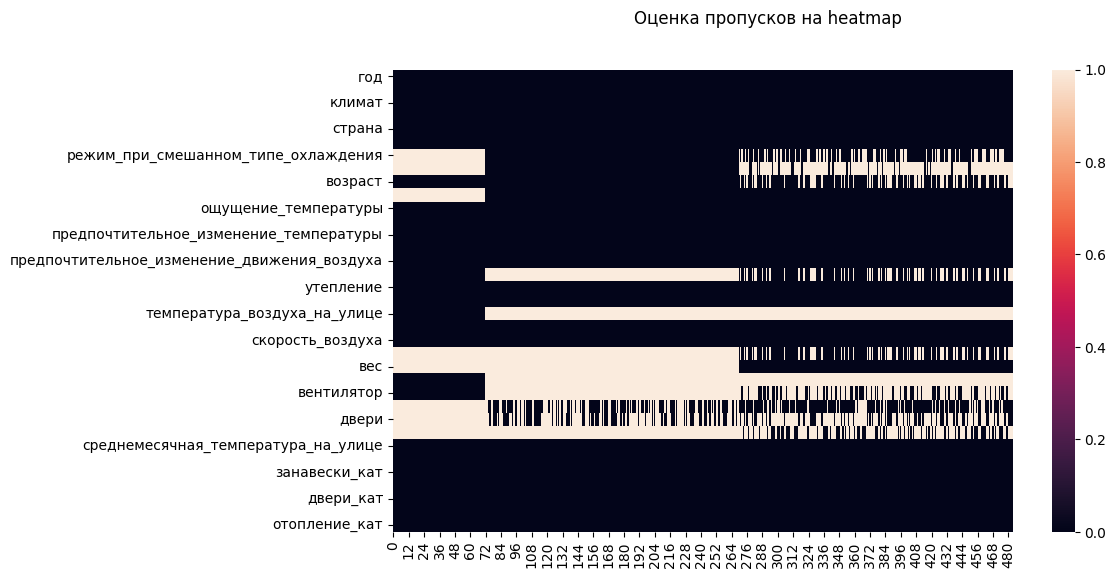



Проверка на дубликаты
Количество полных дубликатов:
 2

Первые 10 строк датасета


,год,время_года,климат,город,страна,способ_охлаждения,режим_при_смешанном_типе_охлаждения,способ_обогрева,возраст,пол,...,окно,двери,отопление,среднемесячная_температура_на_улице,количество_рекламаций,занавески_кат,окно_кат,двери_кат,вентилятор_кат,отопление_кат
0,2011,Лето,Cубтропический океанический,Техас,США,Кондиционирование,NaN,NaN,22.0,NaN,...,NaN,NaN,NaN,28.9,0,закрыто,не определен,не определен,включен,не определен
1,2011,Лето,Cубтропический океанический,Техас,США,Кондиционирование,NaN,NaN,40.0,NaN,...,NaN,NaN,NaN,84.0,0,открыто,не определен,не определен,выключен,не определен
2,2011,Лето,Cубтропический океанический,Техас,США,Кондиционирование,NaN,NaN,42.0,NaN,...,NaN,NaN,NaN,32.8,0,открыто,не определен,не определен,выключен,не определен
3,2011,Лето,Cубтропический океанический,Техас,США,Кондиционирование,NaN,NaN,27.0,NaN,...,NaN,NaN,NaN,28.9,1,закрыто,не определен,не определен,включен,не определен
4,2011,Лето,Cубтропический океанический,Техас,США,Кондиционирование,NaN,NaN,46.0,NaN,...,NaN,NaN,NaN,32.8,0,закрыто,не определен,не определен,включен,не определен
5,2011,Лето,Cубтропический океанический,Техас,США,Кондиционирование,NaN,NaN,27.0,NaN,...,NaN,NaN,NaN,28.9,0,закрыто,не определен,не определен,включен,не определен
6,2011,Лето,Cубтропический океанический,Техас,США,Кондиционирование,NaN,NaN,32.0,NaN,...,NaN,NaN,NaN,32.8,0,закрыто,не определен,не определен,включен,не определен
7,2011,Лето,Cубтропический океанический,Техас,США,Кондиционирование,NaN,NaN,30.0,NaN,...,NaN,NaN,NaN,32.8,0,открыто,не определен,не определен,выключен,не определен
8,2011,Лето,Cубтропический океанический,Техас,США,Кондиционирование,NaN,NaN,43.0,NaN,...,NaN,NaN,NaN,32.8,0,закрыто,не определен,не определен,включен,не определен
9,2011,Лето,Cубтропический океанический,Техас,США,Кондиционирование,NaN,NaN,43.0,NaN,...,NaN,NaN,NaN,31.7,0,открыто,не определен,не определен,выключен,не определен



Описание количественных данных:


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
год,484.0,NaN,NaN,NaN,2011.033058,0.922988,2010.0,2010.0,2011.0,2012.0,2012.0
возраст,413.0,NaN,NaN,NaN,40.634383,11.001301,22.0,35.0,42.0,45.0,65.0
ощущение_температуры,484.0,NaN,NaN,NaN,0.203306,1.091976,-3.0,0.0,0.0,1.0,3.0
ощущение_температуры_bool,484,2,True,382,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ощущение_движения_воздуха_bool,484,2,True,435,NaN,NaN,NaN,NaN,NaN,NaN,NaN
оценка_комфорта,215.0,NaN,NaN,NaN,4.772093,1.261161,1.0,4.0,5.0,6.0,6.0
утепление,484.0,NaN,NaN,NaN,0.634587,0.253103,0.36,0.46,0.59,0.7,2.08
температура_воздуха_в_помещении,484.0,NaN,NaN,NaN,26.072107,7.681363,16.2,23.8,24.6,25.9,77.0
температура_воздуха_на_улице,72.0,NaN,NaN,NaN,24.104167,0.604546,22.8,23.8,24.1,24.4,25.9
rh,484.0,NaN,NaN,NaN,52.97376,13.036204,23.8,42.775,53.75,62.325,85.1



Графическое представление количественных данных:


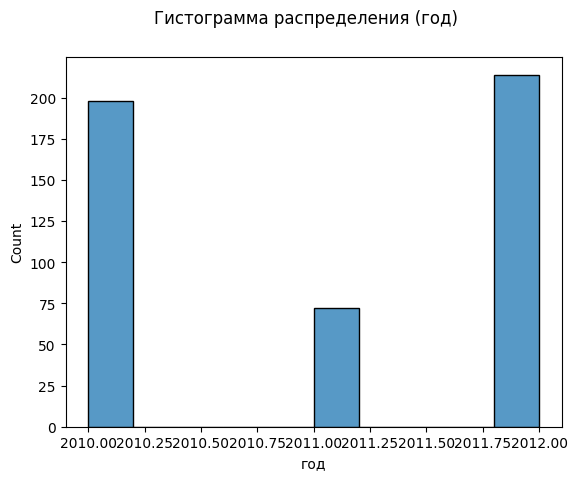

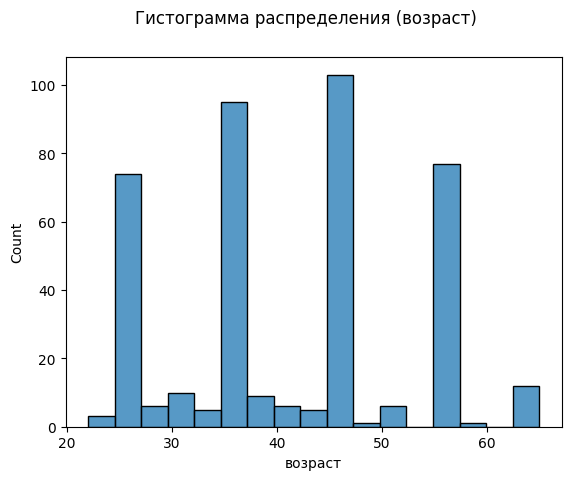

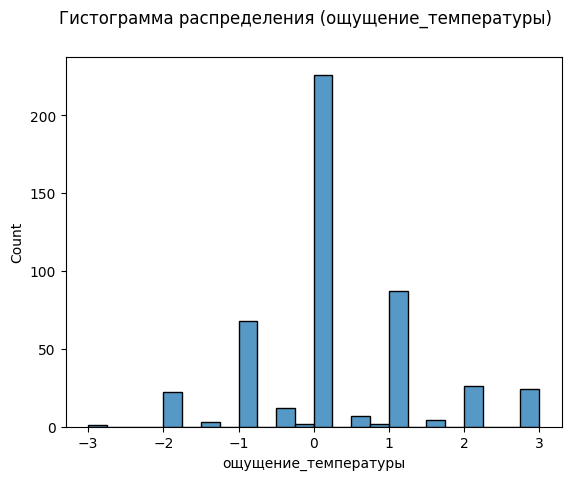

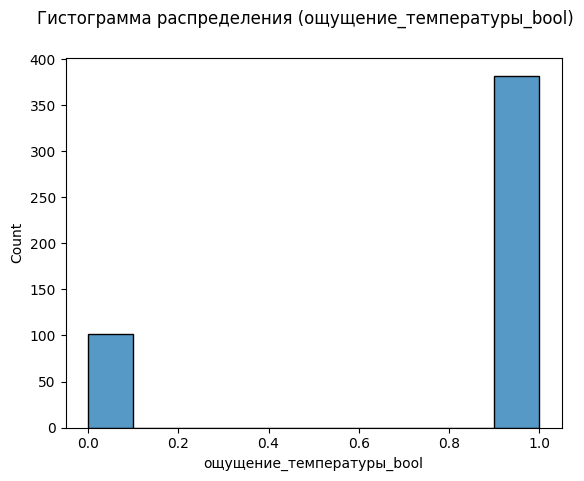

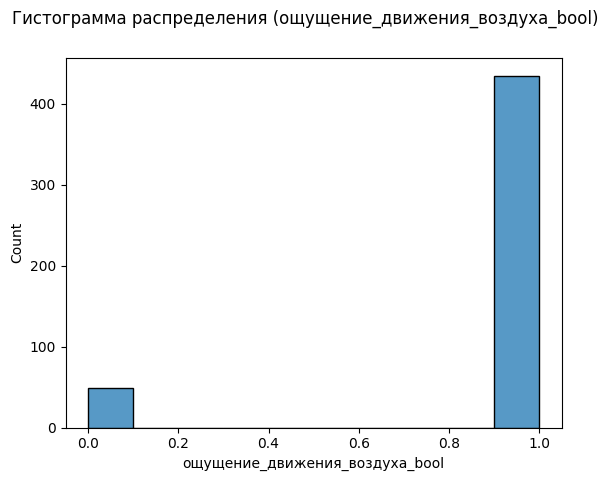

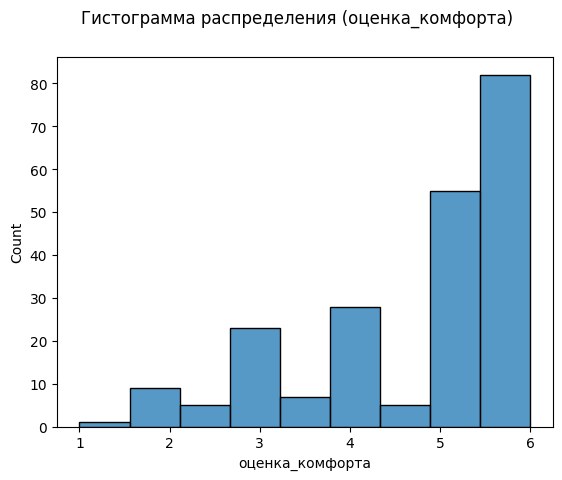

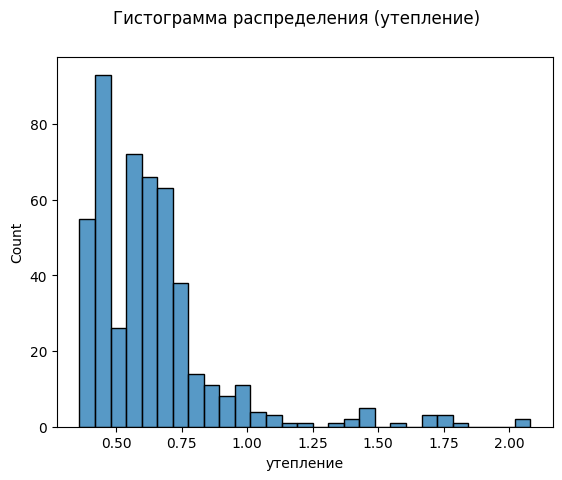

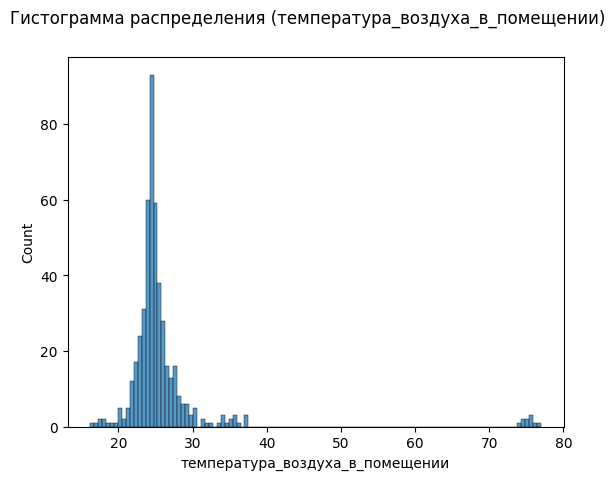

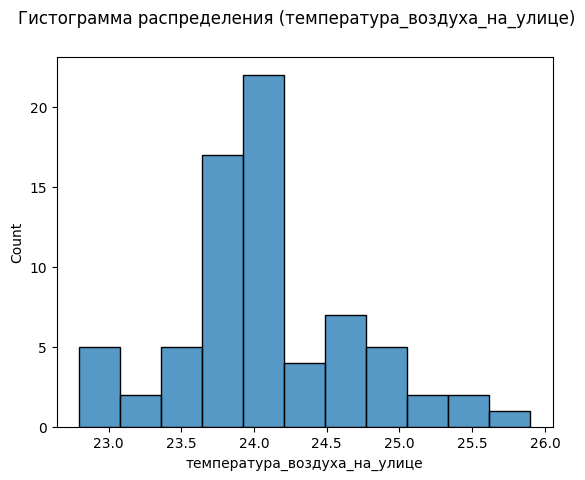

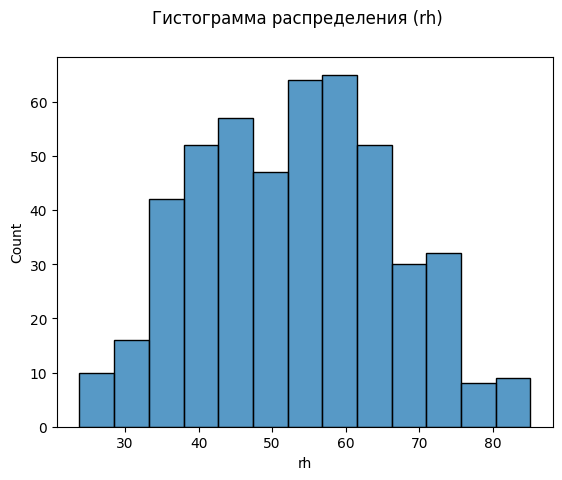

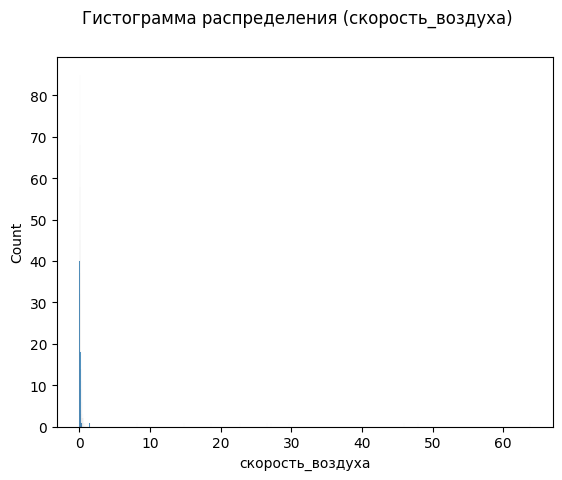

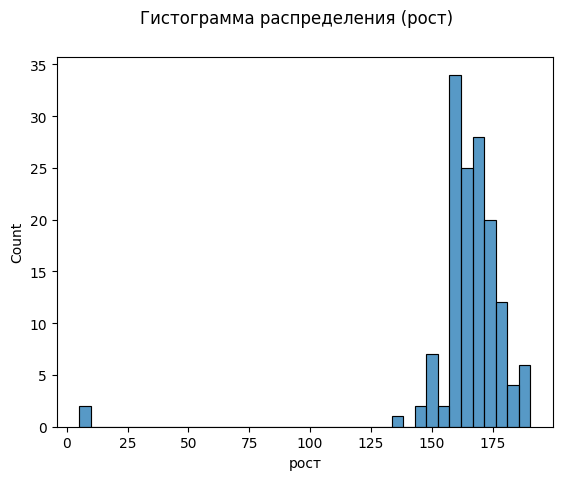

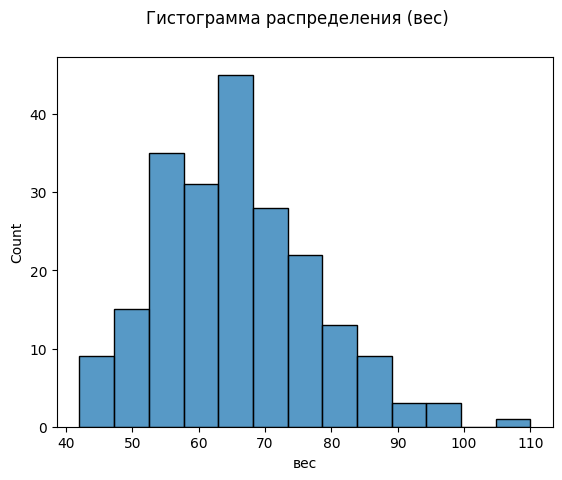

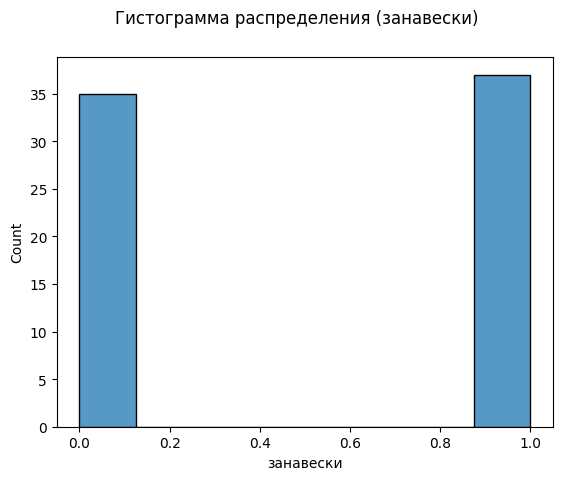

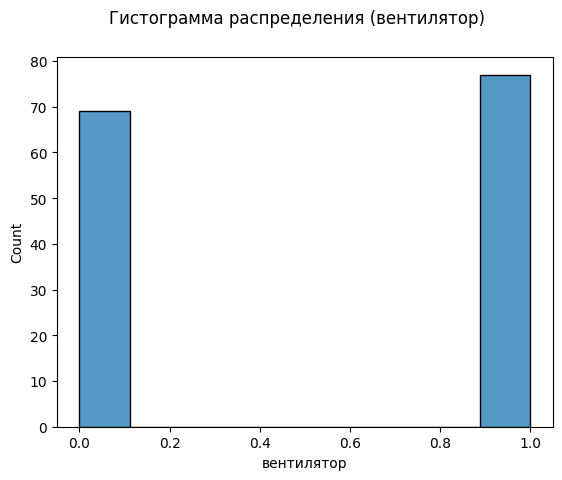

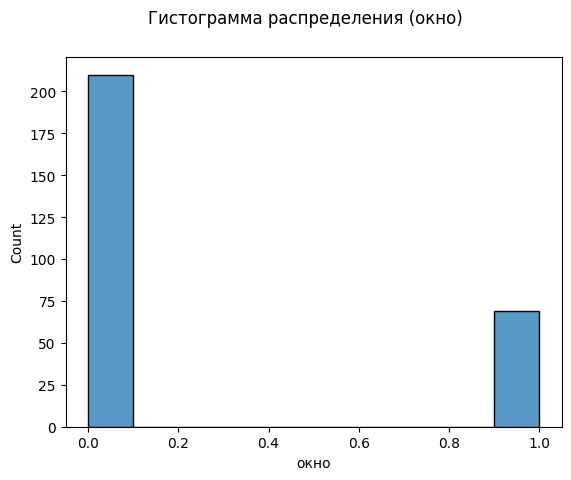

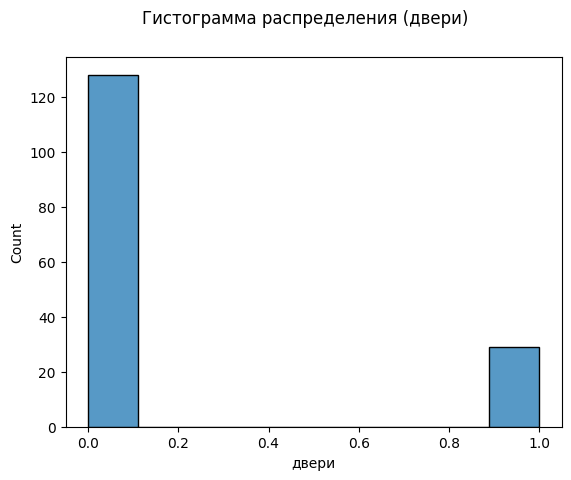

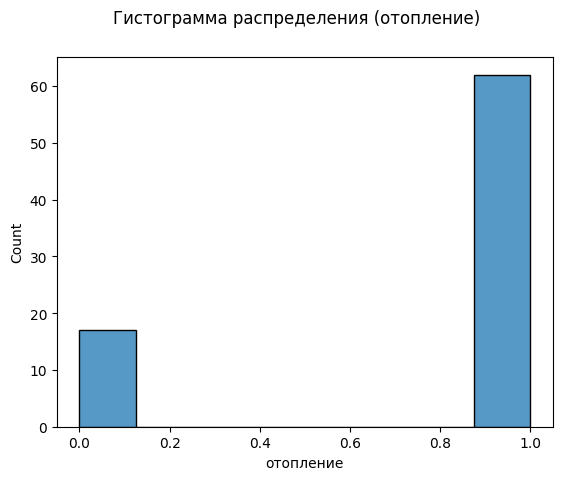

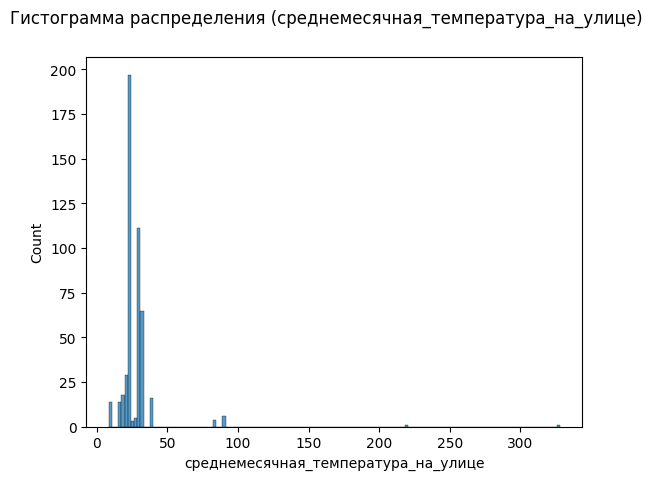

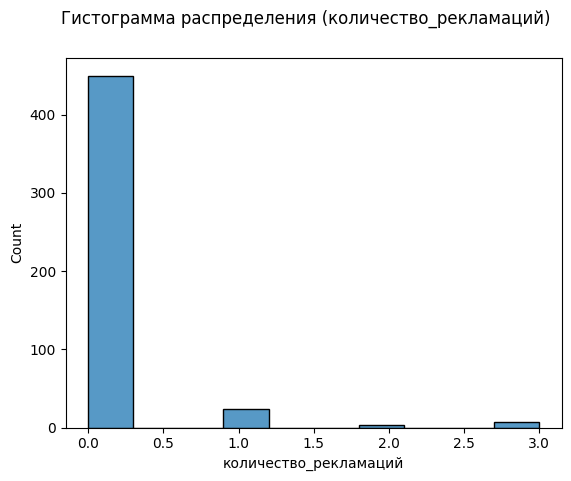



Описание категориальных данных:


,count,unique,top,freq
время_года,484,4,Лето,372
климат,484,6,Cубтропический океанический,269
город,484,8,Сидней,198
страна,484,3,Индия,214
способ_охлаждения,484,3,Смешанный,337
режим_при_смешанном_типе_охлаждения,337,2,Кондиционирование,237
способ_обогрева,222,1,Механическое отопление,222
пол,412,2,Мужской,254
предпочтительное_изменение_температуры,484,5,Без изменений,288
предпочтительное_изменение_движения_воздуха,484,3,Без изменений,291



Графическое представление категориальных данных:


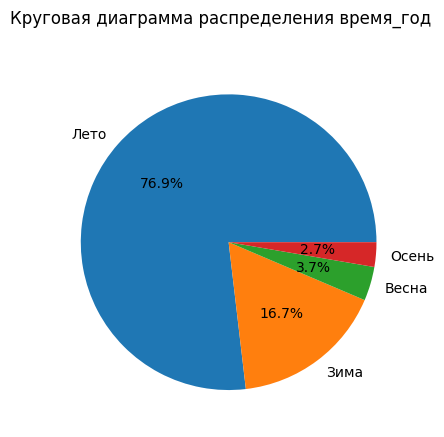

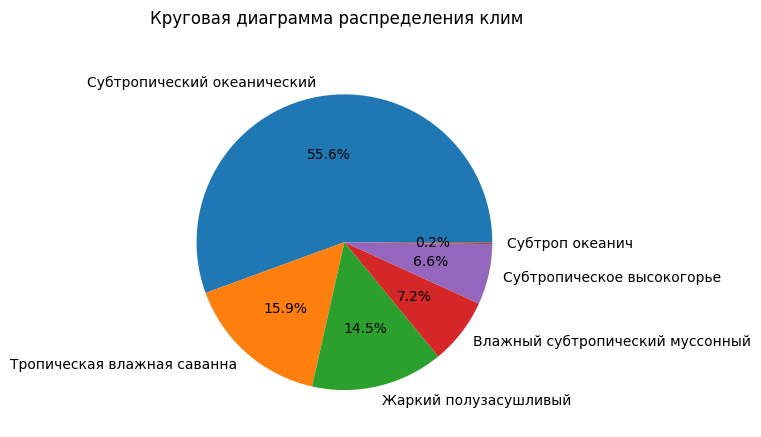

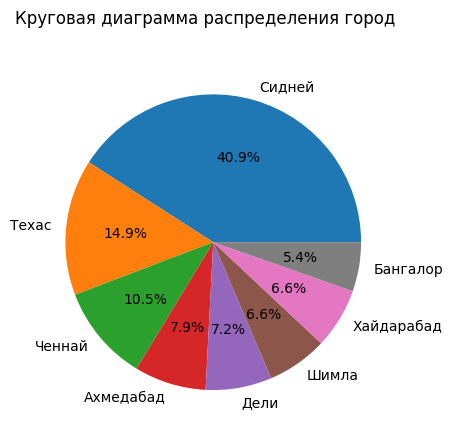

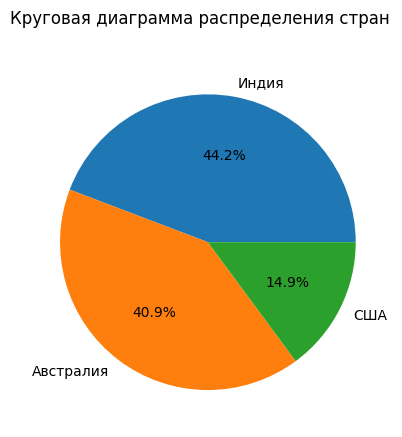

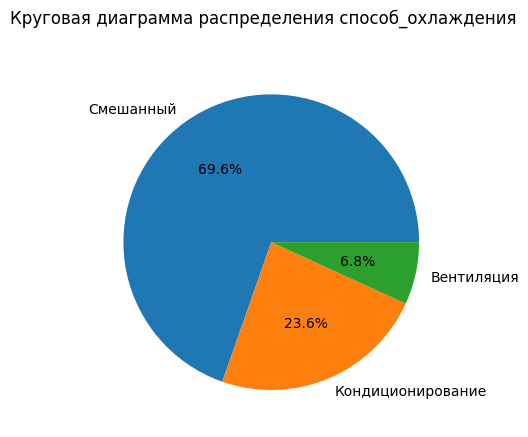

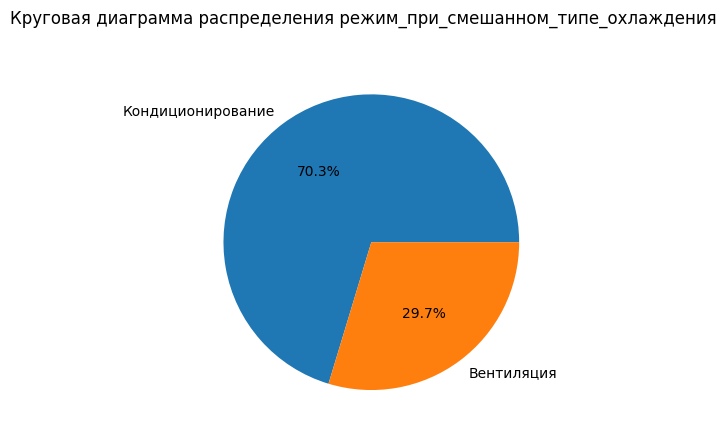

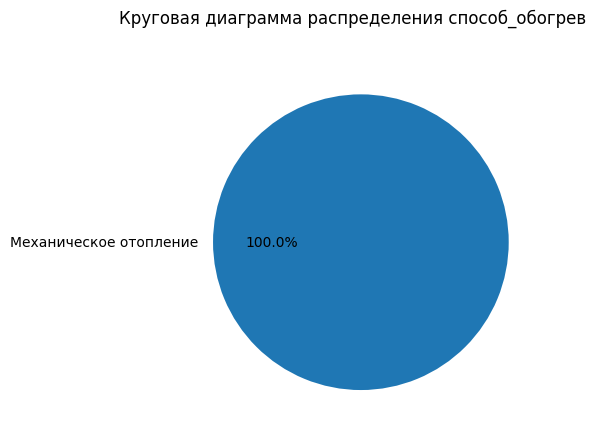

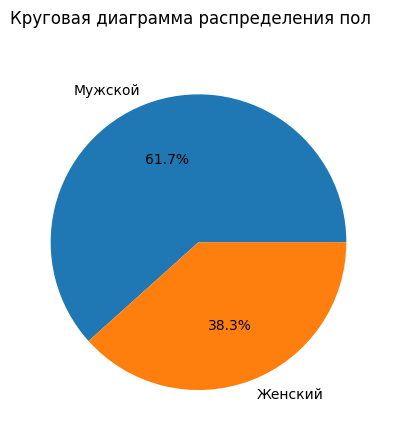

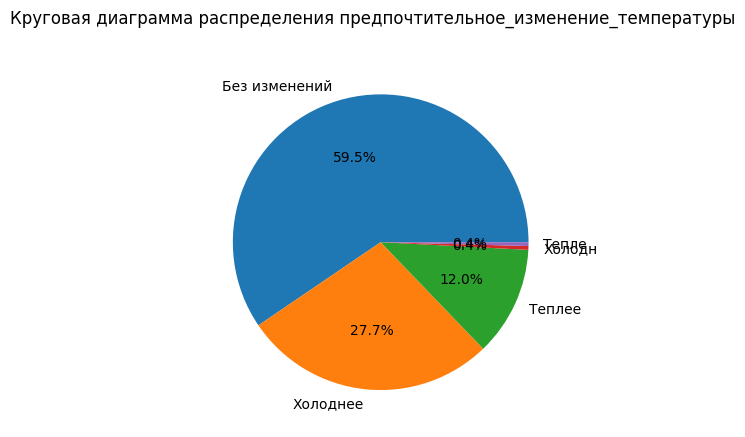

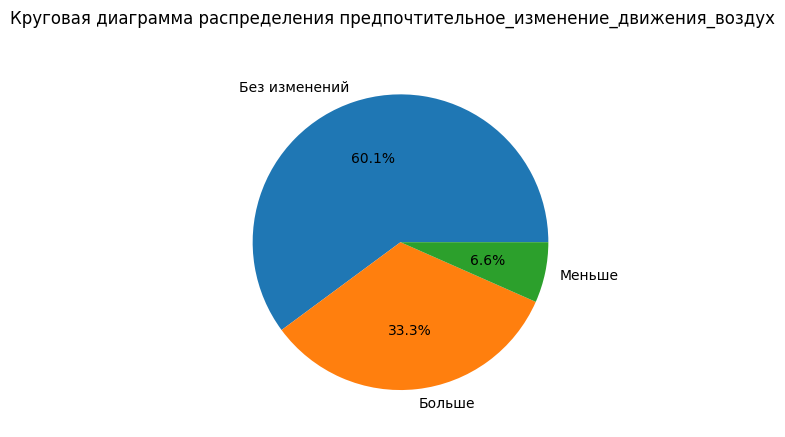

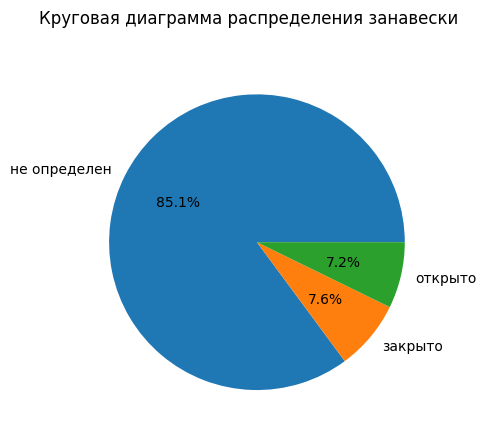

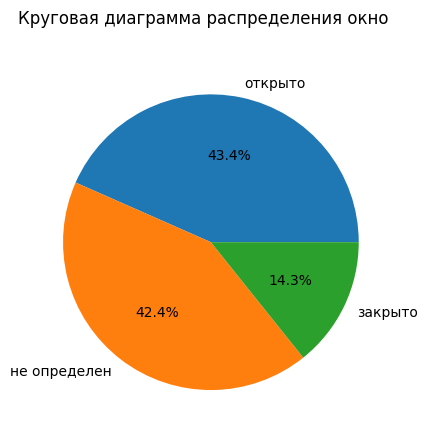

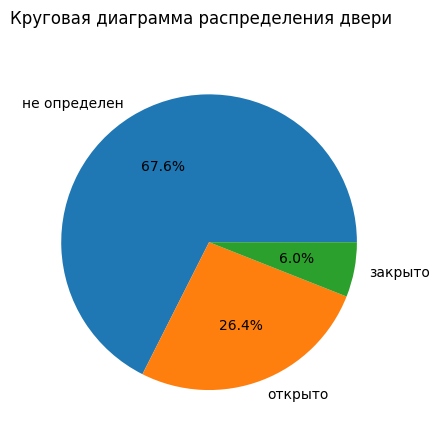

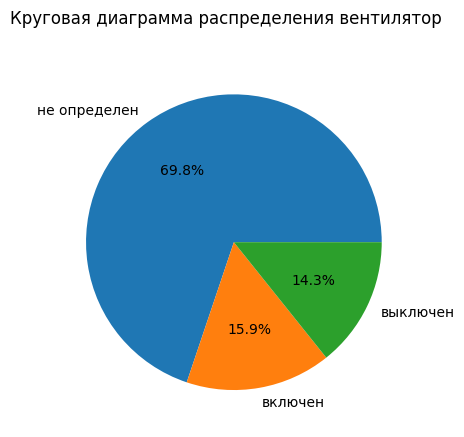

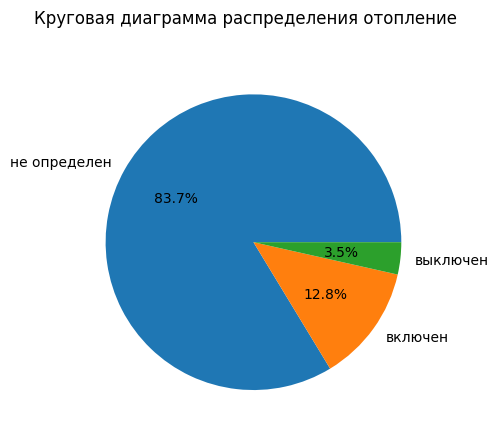

In [46]:
check_data(df)

## Preproccesing

### Выбросы

Посмотрим ящики с усами для всех интересующих нас количественных столбцов для выявления возможных выбросов.

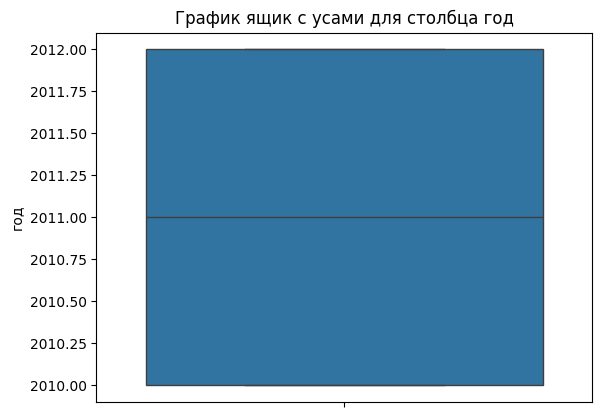

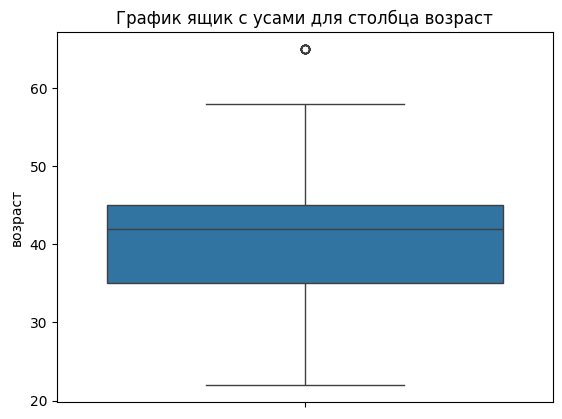

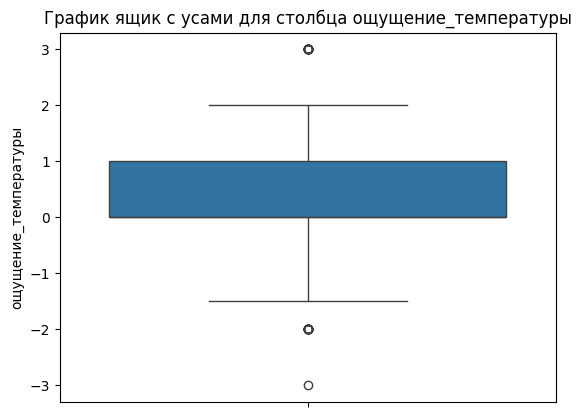

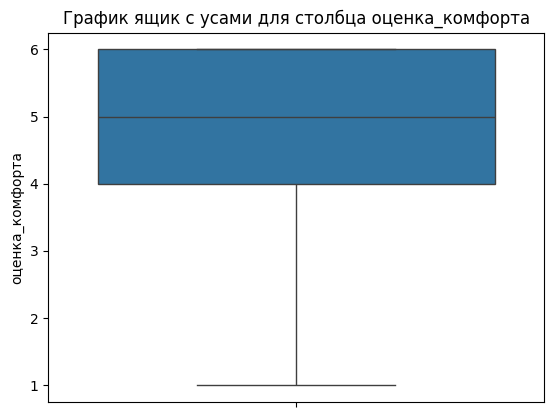

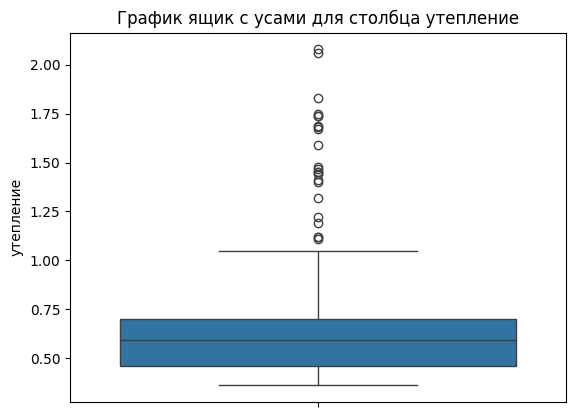

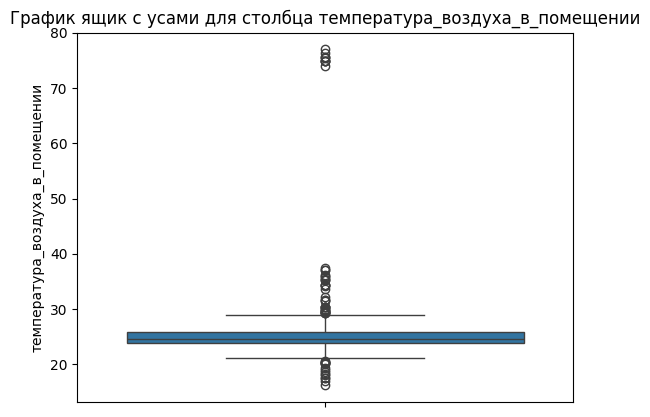

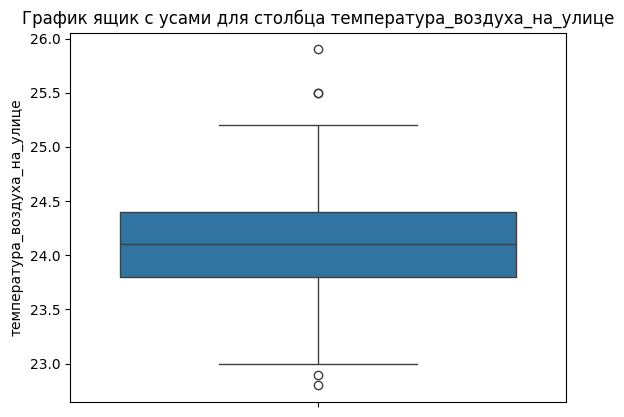

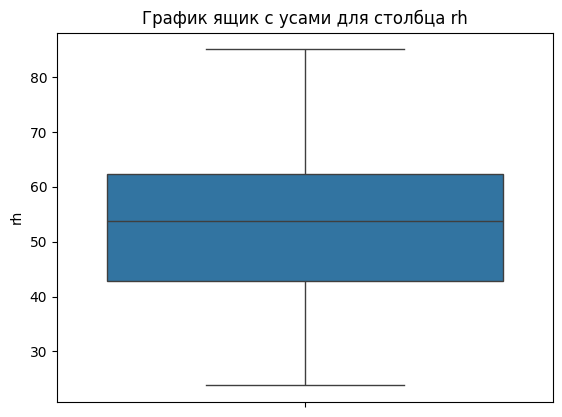

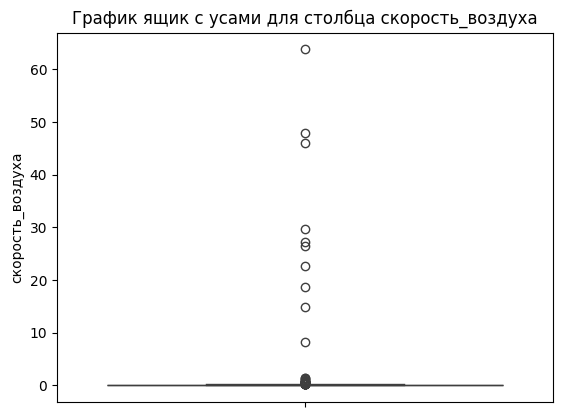

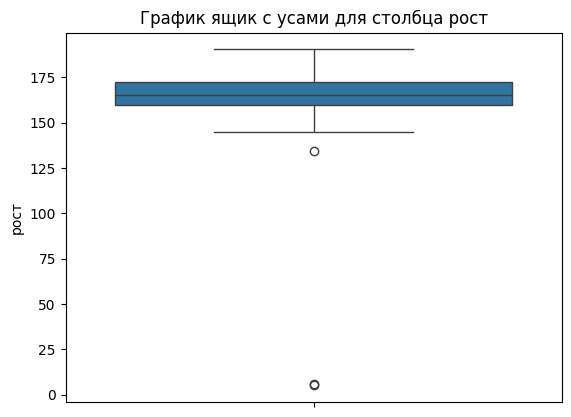

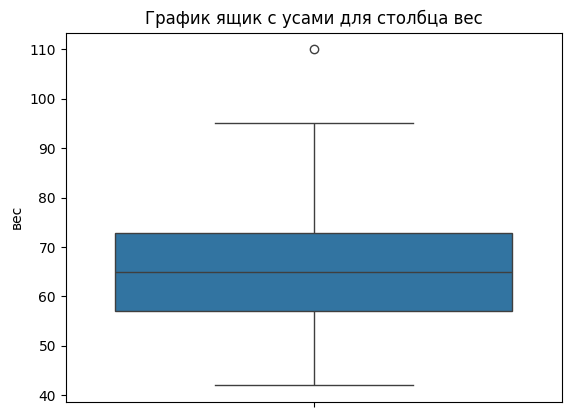

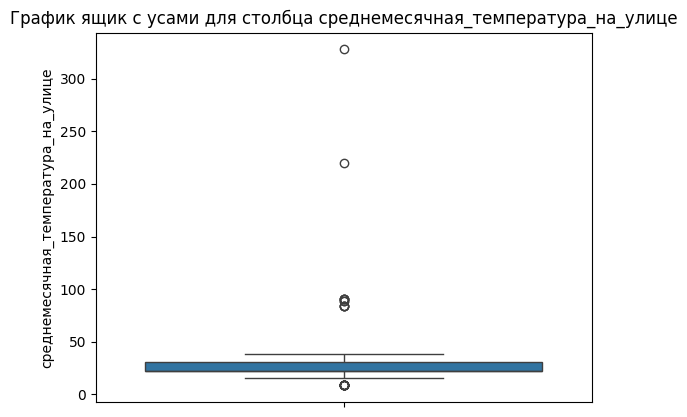

In [51]:
columns = ['год', 'возраст', 'ощущение_температуры', 'оценка_комфорта', 'утепление', 'температура_воздуха_в_помещении',
           'температура_воздуха_на_улице', 'rh', 'скорость_воздуха', 'рост', 'вес', 'среднемесячная_температура_на_улице']
boxplot_chart(df, columns)

In [52]:
df.columns

Index(['год', 'время_года', 'климат', 'город', 'страна', 'способ_охлаждения',
       'режим_при_смешанном_типе_охлаждения', 'способ_обогрева', 'возраст',
       'пол', 'ощущение_температуры', 'ощущение_температуры_bool',
       'предпочтительное_изменение_температуры',
       'ощущение_движения_воздуха_bool',
       'предпочтительное_изменение_движения_воздуха', 'оценка_комфорта',
       'утепление', 'температура_воздуха_в_помещении',
       'температура_воздуха_на_улице', 'rh', 'скорость_воздуха', 'рост', 'вес',
       'занавески', 'вентилятор', 'окно', 'двери', 'отопление',
       'среднемесячная_температура_на_улице', 'количество_рекламаций',
       'занавески_кат', 'окно_кат', 'двери_кат', 'вентилятор_кат',
       'отопление_кат'],
      dtype='object')

Сделаем выводы по этим графикам: <br>
- со столбцом год все нормально.
- со столбцом возраст все нормально.
- к столбцу ощущение_температуры есть вопросы. Взглянем на строки, где встретились выбросы.
- со столбцом оценка_комфорта выбросов не наблюдаем, по значениям будет обговорено позже.
- со стобцом утепление нужно разобраться, разобьем его на группы по временам года и посмотрим график.
- со столбцом температура_воздуха_в_помещении нужно разобраться почему присутствуют выбросы. Скорее всего связано со спецификой работы.
- со столбцом температура_воздуха_на_улице все нормально.
- со столбцом rh на первый взгляд все нормально.
- к столбцу скорость_воздуха есть вопросы. Очень странные выбросы.
- к столбцу рост есть вопросы. Посмотрим почему возникли выбросы и разрешим эту проблему.
- со столбцом вес все нормально.(Не можем утверждать, что присутствуют выбросы)
- со столбцом среднемесячная_температура_на_улице проблемы. Рассмотрим строки с этими значениями более подробно.

In [53]:
df.query('ощущение_температуры < -2 | ощущение_температуры > 2')[['климат', 'время_года', 'страна', 'ощущение_температуры', 
                                                                  'температура_воздуха_на_улице', 'температура_воздуха_в_помещении',
                                                                 'среднемесячная_температура_на_улице']].sort_values(by='ощущение_температуры')

,климат,время_года,страна,ощущение_температуры,температура_воздуха_на_улице,температура_воздуха_в_помещении,среднемесячная_температура_на_улице
350,Тропическая влажная саванна,Весна,Индия,-3.0,NaN,26.6,30.4
76,Cубтропический океанический,Лето,Австралия,3.0,NaN,25.7,22.0
203,Cубтропический океанический,Лето,Австралия,3.0,NaN,24.1,22.0
176,Cубтропический океанический,Лето,Австралия,3.0,NaN,22.9,22.0
211,Cубтропический океанический,Лето,Австралия,3.0,NaN,24.5,22.0
222,Cубтропический океанический,Лето,Австралия,3.0,NaN,24.4,22.0
261,Cубтропический океанический,Лето,Австралия,3.0,NaN,25.2,22.0
208,Cубтропический океанический,Лето,Австралия,3.0,NaN,23.9,22.0
264,Cубтропический океанический,Лето,Австралия,3.0,NaN,24.8,22.0
283,Жаркий полузасушливый,Весна,Индия,3.0,NaN,28.7,31.5


In [54]:
df['ощущение_температуры'].describe().round(4)

count    484.0000
mean       0.2033
std        1.0920
min       -3.0000
25%        0.0000
50%        0.0000
75%        1.0000
max        3.0000
Name: ощущение_температуры, dtype: float64

In [56]:
df['ощущение_температуры'] = df['ощущение_температуры'].apply(lambda x: x if -2 < x < 2 else np.nan)
df['ощущение_температуры'] = df.groupby('климат')['ощущение_температуры'].transform(lambda x: x.fillna(x.median()))
df['ощущение_температуры'].describe().round(4)

count    484.0000
mean       0.0442
std        0.6071
min       -1.5000
25%        0.0000
50%        0.0000
75%        0.0000
max        1.6000
Name: ощущение_температуры, dtype: float64

Обоснование: выбросы, которые выходят за рамки допустимых нам показалось очень странным, потому основываясь на медиане по группам в раздичных климатических поясах, мы заменили данные значения.

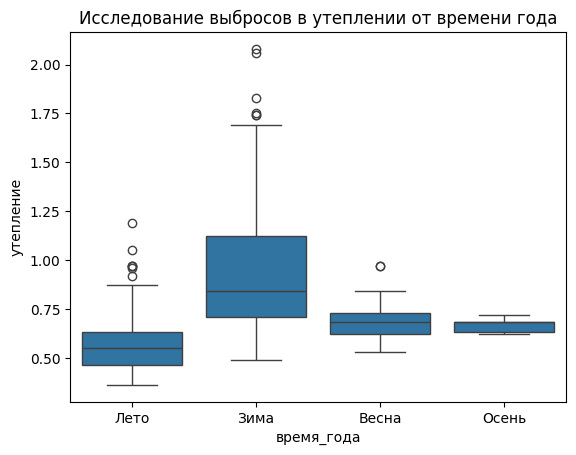

In [57]:
sns.boxplot(data=df, y='утепление', x='время_года')
plt.title('Исследование выбросов в утеплении от времени года')
plt.show()

Выбросы в утеплении летом могут поломать логику нашего исследования, я хочу устранить их путем заменой на групповую медиану по времени года.

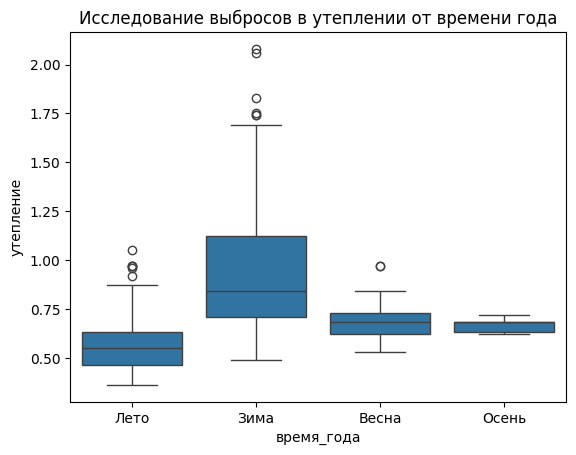

In [58]:
q1 = df[df['время_года'] == 'Лето']['утепление'].quantile(0.25)
q3 = df[df['время_года'] == 'Лето']['утепление'].quantile(0.75)
mask = df[(df['время_года'] == 'Лето') & (df['утепление'] > q3 + 3 * (q3 - q1))].index.to_list()
df.loc[mask, 'утепление'] = df.groupby('время_года')['утепление'].transform('median')
sns.boxplot(data=df, y='утепление', x='время_года')
plt.title('Исследование выбросов в утеплении от времени года')
plt.show()

In [59]:
df.query('температура_воздуха_в_помещении > 40')[['климат', 'время_года', 'страна', 'город', 'ощущение_температуры', 
                                                  'температура_воздуха_на_улице', 'температура_воздуха_в_помещении',
                                                  'среднемесячная_температура_на_улице']].sort_values(by='температура_воздуха_в_помещении')

,климат,время_года,страна,город,ощущение_температуры,температура_воздуха_на_улице,температура_воздуха_в_помещении,среднемесячная_температура_на_улице
45,Cубтропический океанический,Лето,США,Техас,-1.0,23.3,74.0,31.7
1,Cубтропический океанический,Лето,США,Техас,0.0,23.7,74.8,84.0
7,Cубтропический океанический,Лето,США,Техас,0.0,23.6,74.8,32.8
33,Cубтропический океанический,Лето,США,Техас,-1.0,24.2,74.9,32.8
67,Cубтропический океанический,Лето,США,Техас,-0.5,23.8,74.9,84.0
38,Cубтропический океанический,Лето,США,Техас,1.0,24.3,75.5,28.9
54,Cубтропический океанический,Лето,США,Техас,0.0,24.1,75.7,28.9
41,Cубтропический океанический,Лето,США,Техас,0.0,24.1,75.7,31.7
9,Cубтропический океанический,Лето,США,Техас,1.0,24.4,76.4,31.7
23,Cубтропический океанический,Лето,США,Техас,1.6,24.7,77.0,32.8


У данных выбросов есть интересная схожесть - страна, где проходили исследования. США - там температура измеряется в Фаренгейтах. Воспользуемся формулой перевода в Цельсии для таких выбросов.

In [60]:
df['температура_воздуха_в_помещении'] = df['температура_воздуха_в_помещении'].apply(lambda x: x if x < 40 else ((5 / 9) * (x - 32)))
df['температура_воздуха_в_помещении'].describe().round(4)

count    484.0000
mean      25.0127
std        2.7628
min       16.2000
25%       23.8000
50%       24.6000
75%       25.7000
max       37.4000
Name: температура_воздуха_в_помещении, dtype: float64

Как мы видим избавились от выбросов в температуре путем замены их единиц измерения.

In [61]:
df.query('скорость_воздуха > 1').describe(include=object)

,время_года,климат,город,страна,способ_охлаждения,режим_при_смешанном_типе_охлаждения,способ_обогрева,пол,предпочтительное_изменение_температуры,предпочтительное_изменение_движения_воздуха,занавески_кат,окно_кат,двери_кат,вентилятор_кат,отопление_кат
count,13,13,13,13,13,2,1,3,13,13,13,13,13,13,13
unique,2,4,4,2,3,2,1,2,3,3,3,3,2,3,2
top,Лето,Cубтропический океанический,Техас,США,Кондиционирование,Кондиционирование,Механическое отопление,Мужской,Без изменений,Без изменений,закрыто,не определен,не определен,включен,не определен
freq,12,10,10,10,10,1,1,2,9,8,5,10,12,7,12


In [62]:
for el in df['способ_охлаждения'].unique():
  print(el, '\nОписательный анализ по столбцу скорость_воздуха')
  print(df[df['способ_охлаждения'] == el]['скорость_воздуха'].describe().round(4))
  print('\n')

Кондиционирование 
Описательный анализ по столбцу скорость_воздуха
count    114.0000
mean       2.8200
std        9.8907
min        0.0300
25%        0.1000
50%        0.1300
75%        0.2100
max       63.8300
Name: скорость_воздуха, dtype: float64


Смешанный 
Описательный анализ по столбцу скорость_воздуха
count    337.0000
mean       0.1183
std        0.1409
min        0.0000
25%        0.0600
50%        0.0900
75%        0.1200
max        1.4200
Name: скорость_воздуха, dtype: float64


Вентиляция 
Описательный анализ по столбцу скорость_воздуха
count    33.0000
mean      0.2048
std       0.3185
min       0.0000
25%       0.0300
50%       0.0600
75%       0.1900
max       1.4300
Name: скорость_воздуха, dtype: float64




Заполним выбросы медианой по группе относительно способа охлаждения.

In [63]:
q1 = df[df['способ_охлаждения'] == 'Кондиционирование']['скорость_воздуха'].quantile(0.25)
q3 = df[df['способ_охлаждения'] == 'Кондиционирование']['скорость_воздуха'].quantile(0.75)
mask = df[(df['скорость_воздуха'] > 3 * (q3 - q1) + q3) & (df['способ_охлаждения'] == 'Кондиционирование')].index.to_list()
df.loc[mask, 'скорость_воздуха'] = df.groupby('способ_охлаждения')['скорость_воздуха'].transform('median')
for el in df['способ_охлаждения'].unique():
  print(el, '\nОписательный анализ по столбцу скорость_воздуха')
  print(df[df['способ_охлаждения'] == el]['скорость_воздуха'].describe().round(4))
  print('\n')

Кондиционирование 
Описательный анализ по столбцу скорость_воздуха
count    114.0000
mean       0.1483
std        0.0827
min        0.0300
25%        0.1000
50%        0.1300
75%        0.1700
max        0.4500
Name: скорость_воздуха, dtype: float64


Смешанный 
Описательный анализ по столбцу скорость_воздуха
count    337.0000
mean       0.1183
std        0.1409
min        0.0000
25%        0.0600
50%        0.0900
75%        0.1200
max        1.4200
Name: скорость_воздуха, dtype: float64


Вентиляция 
Описательный анализ по столбцу скорость_воздуха
count    33.0000
mean      0.2048
std       0.3185
min       0.0000
25%       0.0300
50%       0.0600
75%       0.1900
max       1.4300
Name: скорость_воздуха, dtype: float64




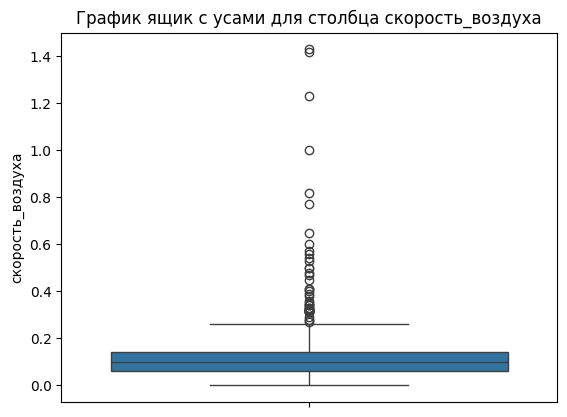

In [64]:
boxplot_chart(df, ['скорость_воздуха'])

In [66]:
df.query(f'рост < {df["рост"].quantile(0.05)}')[['страна', 'рост']]

,страна,рост
287,Индия,5.23
301,Индия,147.30
306,Индия,5.74
325,Индия,144.80
340,Индия,134.60


Можем предпложить, что в Индии длина измеряется по-своему. Возможно это футы или Ilahi Gaz. Но если переводить в Ilahi Gaz, то можно ужаснутся большими значениями. Будем считать это футами так как при переводе в сантиметры будут выходить весьма хорошие значения, не противоречущие среднему росту в Индии

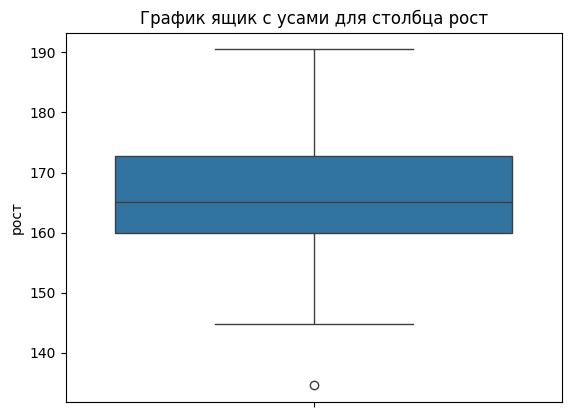

,год,время_года,климат,город,страна,способ_охлаждения,режим_при_смешанном_типе_охлаждения,способ_обогрева,возраст,пол,...,окно,двери,отопление,среднемесячная_температура_на_улице,количество_рекламаций,занавески_кат,окно_кат,двери_кат,вентилятор_кат,отопление_кат
340,2012,Зима,Субтропическое высокогорье,Шимла,Индия,Смешанный,Кондиционирование,Механическое отопление,25.0,Женский,...,0.0,NaN,NaN,8.5,0,не определен,открыто,не определен,не определен,не определен


In [67]:
df['рост'] = df['рост'].apply(lambda x: x * 0.3048 * 100 if x < 10 else x)
boxplot_chart(df, ['рост'])
df.query('рост < 140')

У нас остался один предполагаемый выброс. Мы не можем его таким считать, так как это возможно особенность человека.

In [68]:
df.query(f'среднемесячная_температура_на_улице > {df["среднемесячная_температура_на_улице"].quantile(0.95)}')[['климат', 'время_года', 'страна', 'город', 'ощущение_температуры', 
                                                                                                               'температура_воздуха_на_улице', 'температура_воздуха_в_помещении',
                                                                                                               'среднемесячная_температура_на_улице']].sort_values(by='среднемесячная_температура_на_улице')

,климат,время_года,страна,город,ощущение_температуры,температура_воздуха_на_улице,температура_воздуха_в_помещении,среднемесячная_температура_на_улице
1,Cубтропический океанический,Лето,США,Техас,0.0,23.7,23.777778,84.0
14,Cубтропический океанический,Лето,США,Техас,-1.5,23.0,23.200000,84.0
67,Cубтропический океанический,Лето,США,Техас,-0.5,23.8,23.833333,84.0
44,Cубтропический океанический,Лето,США,Техас,0.0,23.9,24.000000,84.0
34,Cубтропический океанический,Лето,США,Техас,0.0,24.1,24.300000,89.0
39,Cубтропический океанический,Лето,США,Техас,0.0,24.4,24.400000,89.0
30,Cубтропический океанический,Лето,США,Техас,-1.3,24.2,24.300000,91.0
20,Cубтропический океанический,Лето,США,Техас,0.0,23.6,23.600000,91.0
68,Cубтропический океанический,Лето,США,Техас,1.5,25.9,26.000000,91.0
28,Cубтропический океанический,Лето,США,Техас,-0.5,24.6,23.900000,91.0


США - там температура измеряется в Фаренгейтах. Воспользуемся формулой перевода в Цельсии для таких выбросов.

count    482.0000
mean      22.2437
std        8.2323
min        0.4321
25%       22.0000
50%       22.0000
75%       29.5000
max       31.7000
Name: среднемесячная_температура_на_улице, dtype: float64


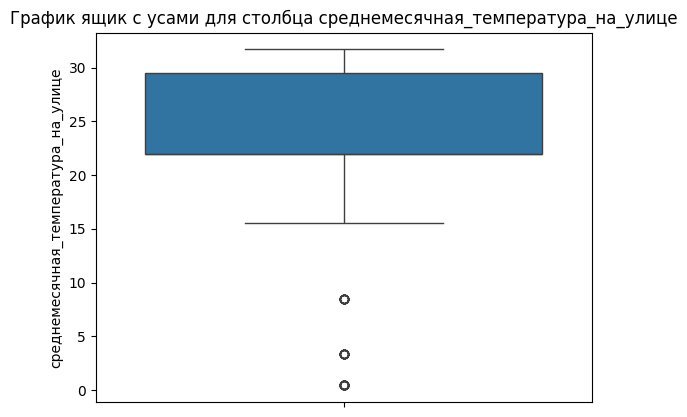

In [94]:
df['среднемесячная_температура_на_улице'] = df['среднемесячная_температура_на_улице'].apply(lambda x: x if x < df["среднемесячная_температура_на_улице"].quantile(0.95) else ((5 / 9) * (x - 32)))
print(df['среднемесячная_температура_на_улице'].describe().round(4))
boxplot_chart(df, ['среднемесячная_температура_на_улице'])

Оставшиеся выбросы заменим на NaN для последующей замены на этапе заполнения пропусков

In [95]:
df['среднемесячная_температура_на_улице'] = df['среднемесячная_температура_на_улице'].apply(lambda x: x if x < 100 else np.nan)
df['среднемесячная_температура_на_улице'].describe().round(4)

count    482.0000
mean      22.2437
std        8.2323
min        0.4321
25%       22.0000
50%       22.0000
75%       29.5000
max       31.7000
Name: среднемесячная_температура_на_улице, dtype: float64

### Дубликаты

Выявим и заменим неявные дубликаты

In [96]:
duplicates = df[df.duplicated()]
duplicates

,год,время_года,климат,город,страна,способ_охлаждения,режим_при_смешанном_типе_охлаждения,способ_обогрева,возраст,пол,...,окно,двери,отопление,среднемесячная_температура_на_улице,количество_рекламаций,занавески_кат,окно_кат,двери_кат,вентилятор_кат,отопление_кат


In [97]:
df = df.drop_duplicates()

In [98]:
for i in df.columns:
    if df[i].dtype == 'object':
        print(i, df[i].unique())

время_года ['Лето' 'Зима' 'Весна' 'Осень']
климат ['Субтропический океанический' 'Субтропическое высокогорье'
 'Жаркий полузасушливый' 'Тропическая влажная саванна'
 'Влажный субтропический муссонный']
город ['Сидней' 'Техас' 'Шимла' 'Хайдарабад' 'Бангалор' 'Ахмедабад' 'Ченнай'
 'Дели']
страна ['Австралия' 'США' 'Индия']
способ_охлаждения ['Смешанный' 'Кондиционирование' 'Вентиляция']
режим_при_смешанном_типе_охлаждения ['Кондиционирование' 'Вентиляция' nan]
способ_обогрева ['Механическое отопление' nan]
пол ['Женский' 'Мужской' nan]
предпочтительное_изменение_температуры ['Теплее' 'Без изменений' 'Холоднее']
предпочтительное_изменение_движения_воздуха ['Меньше' 'Без изменений' 'Больше']
занавески_кат ['не определен' 'закрыто' 'открыто']
окно_кат ['не определен' 'закрыто' 'открыто']
двери_кат ['не определен' 'открыто' 'закрыто']
вентилятор_кат ['не определен' 'включен' 'выключен']
отопление_кат ['не определен' 'включен' 'выключен']


Заменим опечатки на правильные значения

In [99]:
df['климат'] = df['климат'].map({'Cубтроп океанич': 'Субтропический океанический',
                                 'Cубтропический океанический': 'Субтропический океанический'
                                }).fillna(df['климат'])

In [100]:
df['климат'].unique()

array(['Субтропический океанический', 'Субтропическое высокогорье',
       'Жаркий полузасушливый', 'Тропическая влажная саванна',
       'Влажный субтропический муссонный'], dtype=object)

In [101]:
df['предпочтительное_изменение_температуры'] = df['предпочтительное_изменение_температуры'].map({'Холодн': 'Холоднее',
                                                                                                'Тепле': 'Теплее'}).fillna(df['предпочтительное_изменение_температуры'])


In [102]:
df['предпочтительное_изменение_температуры'].unique()

array(['Теплее', 'Без изменений', 'Холоднее'], dtype=object)

### Пропуски

In [135]:
# Заполнение пропусков 
""" Оно требуется в столбцах возраст ( 71 пропуск ), пол ( 72 пропуска ), 
                             рост ( 341 пропуск ) , вес ( 270 пропусков )  оценка_комфорта ( 269 пропусков ),
                             отопление ( 405 пропусков ) """

# В других столбцах где присутствуют пропуски заполнение точно не требуется

# для начали проанализируем данные столбцы по странам
for col in ['возраст', 'пол', 'рост', 'вес', 'оценка_комфорта', 'отопление']:
    print(col)
    print()
    for cntr in df['страна'].unique():
        print(cntr.ljust(8), '\t', 
              'Кол-во не пустых значений:', str(df[(df['страна'] == cntr) & (df[col].notna())].shape[0]).ljust(3), '\t',
              'Кол-во Nan:', df[(df['страна'] == cntr) & (df[col].isna())].shape[0])
    print()

возраст

Австралия 	 Кол-во не пустых значений: 198 	 Кол-во Nan: 0
США      	 Кол-во не пустых значений: 72  	 Кол-во Nan: 0
Индия    	 Кол-во не пустых значений: 212 	 Кол-во Nan: 0

пол

Австралия 	 Кол-во не пустых значений: 198 	 Кол-во Nan: 0
США      	 Кол-во не пустых значений: 0   	 Кол-во Nan: 72
Индия    	 Кол-во не пустых значений: 212 	 Кол-во Nan: 0

рост

Австралия 	 Кол-во не пустых значений: 0   	 Кол-во Nan: 198
США      	 Кол-во не пустых значений: 0   	 Кол-во Nan: 72
Индия    	 Кол-во не пустых значений: 212 	 Кол-во Nan: 0

вес

Австралия 	 Кол-во не пустых значений: 0   	 Кол-во Nan: 198
США      	 Кол-во не пустых значений: 0   	 Кол-во Nan: 72
Индия    	 Кол-во не пустых значений: 212 	 Кол-во Nan: 0

оценка_комфорта

Австралия 	 Кол-во не пустых значений: 0   	 Кол-во Nan: 198
США      	 Кол-во не пустых значений: 72  	 Кол-во Nan: 0
Индия    	 Кол-во не пустых значений: 181 	 Кол-во Nan: 31

отопление

Австралия 	 Кол-во не пустых значений: 198 	 Кол-во Nan: 

In [136]:
# разобьем на разные группы для заполнять для каждой страны отдельно
df_au = df[df['страна'] == 'Австралия'].copy()
df_us = df[df['страна'] == 'США'].copy()
df_in = df[df['страна'] == 'Индия'].copy()

target = 'отопление'

In [137]:
# Заметим, что пустые значения только у страны США, в других заполненны, так что просто оставим np.nan

# Возраст — медиана по полу и по странам (можно заметить что все 71 пропуск из страны Индии"""
df_in['возраст'] = df_in.groupby('пол')['возраст'].transform(lambda x: x.fillna(x.median()))

# Рост - заметим что у страны США и Австралия не заполненно, так что оставим как np.nan
# А вот у Индии заполним по полу средним значением
mn_india_hght = df_in.groupby('пол')['рост'].mean()

df_in['рост'] = df_in.apply(
    lambda x: (mn_india_hght[x['пол']] if pd.isna(x['рост']) else (np.nan if pd.isna(x['рост']) else x['рост'])), axis=1)

# Видим, что у столбца вес страны США и Австралии отсутвуют заполненные значения, так что их оставим пустыми

# Видим, что у оценки комфорта аналогичная ситуация как и у роста, однако заполненны значения у страны США
# У Индии заполним по времени года и способу охдаждения средним значением, у страны Австралия оставим np.nan
mn_india_cmfrt = df_in.groupby(['время_года', 'способ_охлаждения'])['оценка_комфорта'].mean()
df_in['оценка_комфорта'] = df_in.apply(lambda x: (
        mn_india_cmfrt.get((x['время_года'], x['способ_охлаждения']), x['оценка_комфорта'])
        if pd.isna(x['оценка_комфорта'])
        else x['оценка_комфорта']), axis=1)

# Также заполним пропуски 'среднемесячная_температура_на_улице' после удаления выбросов - средним по климату
crdmschn_temp = 'среднемесячная_температура_на_улице'
df_au[crdmschn_temp] = df_au.groupby('климат')[crdmschn_temp].transform(lambda x: x.fillna(x.mean()))
df_us[crdmschn_temp] = df_us.groupby('климат')[crdmschn_temp].transform(lambda x: x.fillna(x.mean()))
df_in[crdmschn_temp] = df_in.groupby('климат')[crdmschn_temp].transform(lambda x: x.fillna(x.mean()))

In [138]:
df = pd.concat([df_us, df_au, df_in])

#### Австралия

In [139]:
# нет данных о отоплении в Австралии

In [140]:
# отобразим таблицу с помощью которой сможем понять 
df_au.groupby(['время_года', 'климат', 'отопление'], dropna=False).agg({
    'среднемесячная_температура_на_улице' : 'median',
     'температура_воздуха_в_помещении' : 'median',
     'отопление': 'size'
})

,,,среднемесячная_температура_на_улице,температура_воздуха_в_помещении,отопление
время_года,климат,отопление,,,
Лето,Субтропический океанический,0.0,22.0,24.3,198


In [141]:
# температура на улице схожа с температурой в помещении (примерно 20 градусов) => отопление = 0
df_au[target] = df_au[target].fillna(0)

#### США

In [142]:
df_us[target].isna().mean()

np.float64(0.0)

In [143]:
# нет данных о отоплении в США

In [144]:
df_us.groupby(['время_года', 'климат', 'отопление'], dropna=False).agg({
    'среднемесячная_температура_на_улице' : 'median',
     'температура_воздуха_в_помещении' : 'median',
     'отопление': 'size'
})

,,,среднемесячная_температура_на_улице,температура_воздуха_в_помещении,отопление
время_года,климат,отопление,,,
Лето,Субтропический океанический,0.0,28.9,24.1,72


In [145]:
# температура на улице в среднем 30 градусов а в помещении 24, вряд ли кто то будет включать отопление в +30 => отопление=0
df_us[target] = df_us[target].fillna(0)

#### Индия

In [146]:
round(df_in[target].isna().mean(), 4) # 60 процентов информации отсутствует

np.float64(0.0)

In [147]:
df_in.groupby(['время_года', 'климат', 'отопление'], dropna=False).agg({
    'среднемесячная_температура_на_улице' : 'median',
     'температура_воздуха_в_помещении' : 'median',
     'отопление': 'size'
}).round(4)

среднемесячная_температура_на_улице  \
время_года климат                           отопление                                        
Весна      Жаркий полузасушливый            0.0                                    31.5000   
           Тропическая влажная саванна      0.0                                    30.4000   
Зима       Влажный субтропический муссонный 0.0                                    15.5000   
                                            1.0                                    15.5000   
           Жаркий полузасушливый            0.0                                    21.6000   
                                            1.0                                    21.3000   
           Субтропическое высокогорье       1.0                                     8.5000   
           Тропическая влажная саванна      0.0                                    30.8000   
                                            1.0                                    29.9000   
Лето       Влажный субтропический муссонный 0.0                                    30.9000   
                                            1.0                                    30.9000   
           Жаркий полузасушливый            0.0                                    29.5000   
                                            1.0                                    29.5000   
           Субтропическое высокогорье       0.0                                    18.5000   
           Тропическая влажная саванна      1.0                                    17.0944   
Осень      Жаркий полузасушливый            0.0                                    25.7000   
           Тропическая влажная саванна      0.0                                    29.7000   

                                                       температура_воздуха_в_помещении  \
время_года климат                           отопление                                    
Весна      Жаркий полузасушливый            0.0                                  27.90   
           Тропическая влажная саванна      0.0                                  26.60   
Зима       Влажный субтропический муссонный 0.0                                  25.30   
                                            1.0                                  22.85   
           Жаркий полузасушливый            0.0                                  26.90   
                                            1.0                                  25.30   
           Субтропическое высокогорье       1.0                                  20.20   
           Тропическая влажная саванна      0.0                                  26.70   
                                            1.0                                  25.90   
Лето       Влажный субтропический муссонный 0.0                                  35.80   
                                            1.0                                  24.40   
           Жаркий полузасушливый            0.0                                  29.40   
                                            1.0                                  25.50   
           Субтропическое высокогорье       0.0                                  22.40   
           Тропическая влажная саванна      1.0                                  25.95   
Осень      Жаркий полузасушливый            0.0                                  28.10   
           Тропическая влажная саванна      0.0                                  26.20   

                                                       отопление  
время_года климат                           отопление             
Весна      Жаркий полузасушливый            0.0                7  
           Тропическая влажная саванна      0.0               11  
Зима       Влажный субтропический муссонный 0.0                2  
                                            1.0               12  
           Жаркий полузасушливый            0.0               26  
                                            1.0                1  
           Субтропиче

In [148]:
# основываясь на данных из таблицы вручную проставим значения отопления для каждого сезона и климата

# весна
df_in.loc[(df_in['время_года'] == 'Весна'), target] = 0

# зима
df_in.loc[(df_in['время_года'] == 'Зима') & (df_in['климат'] == 'Влажный субтропический муссонный') & (df_in[target].isnull()), target] = 1
df_in.loc[(df_in['время_года'] == 'Зима') & (df_in['климат'] == 'Жаркий полузасушливый') & (df_in[target].isnull()), target] = 0
df_in.loc[(df_in['время_года'] == 'Зима') & (df_in['климат'] == 'Субтропическое высокогорье') & (df_in[target].isnull()), target] = 1
df_in.loc[(df_in['время_года'] == 'Зима') & (df_in['климат'] == 'Тропическая влажная саванна') & (df_in[target].isnull()), target] = 0

# лето
df_in.loc[(df_in['время_года'] == 'Лето') & (df_in['климат'] == 'Влажный субтропический муссонный') & (df_in[target].isnull()), target] = 0
df_in.loc[(df_in['время_года'] == 'Лето') & (df_in['климат'] == 'Жаркий полузасушливый') & (df_in[target].isnull()), target] = 0
df_in.loc[(df_in['время_года'] == 'Лето') & (df_in['климат'] == 'Субтропическое высокогорье') & (df_in[target].isnull()), target] = 0
df_in.loc[(df_in['время_года'] == 'Лето') & (df_in['климат'] == 'Тропическая влажная саванна'), target] = 1

# осень
df_in.loc[(df_in['время_года'] == 'Осень'), target] = 0

#### Соединим полученные по каждой стране данные

In [149]:
df = pd.concat([df_au, df_us, df_in])

In [150]:
df.isna().sum()

год                                              0
время_года                                       0
климат                                           0
город                                            0
страна                                           0
способ_охлаждения                                0
режим_при_смешанном_типе_охлаждения            147
способ_обогрева                                260
возраст                                          0
пол                                             72
ощущение_температуры                             0
ощущение_температуры_bool                        0
предпочтительное_изменение_температуры           0
ощущение_движения_воздуха_bool                   0
предпочтительное_изменение_движения_воздуха      0
оценка_комфорта                                229
утепление                                        0
температура_воздуха_в_помещении                  0
температура_воздуха_на_улице                   410
rh                             

Мы оставили только те пропуски, которые заменять не стоит в условиях интересующей нас задачи.

Вспомним, что возраст у нас типа float. Так как пропуски мы заполнили в этом столбце, можем изменить тип данных.

In [151]:
df['возраст'] = df['возраст'].astype(int)

### Результат предобработки

Воспользуемся нашей функцией для описательного и графического анализа данных

Изучим исходные данные
<class 'pandas.core.frame.DataFrame'>
Index: 482 entries, 72 to 481
Data columns (total 35 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   год                                          482 non-null    int64  
 1   время_года                                   482 non-null    object 
 2   климат                                       482 non-null    object 
 3   город                                        482 non-null    object 
 4   страна                                       482 non-null    object 
 5   способ_охлаждения                            482 non-null    object 
 6   режим_при_смешанном_типе_охлаждения          335 non-null    object 
 7   способ_обогрева                              222 non-null    object 
 8   возраст                                      482 non-null    int64  
 9   пол                                          410 non-null

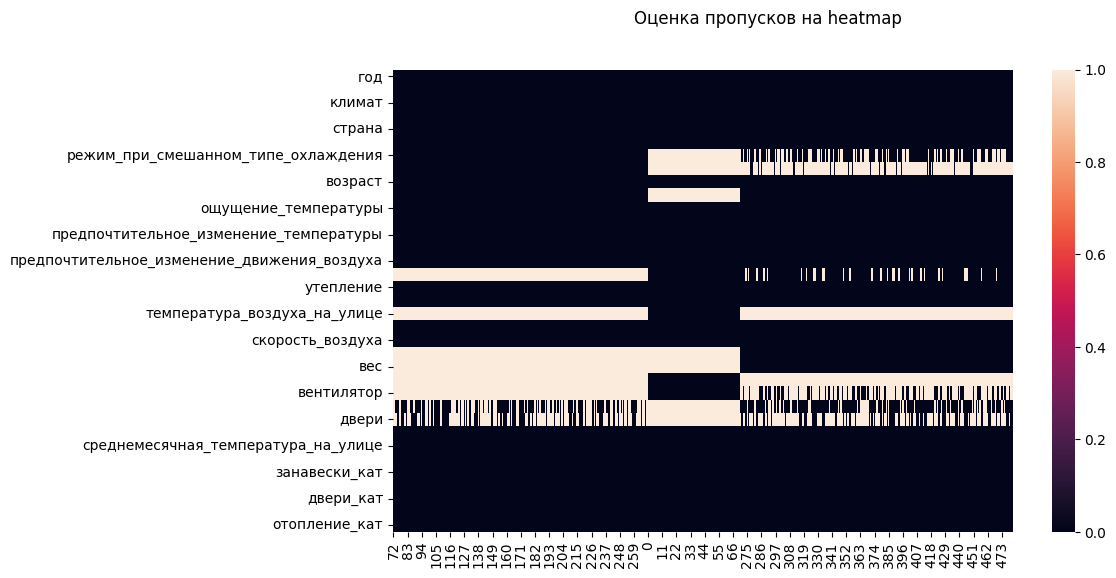



Проверка на дубликаты
Количество полных дубликатов:
 0

Первые 10 строк датасета


,год,время_года,климат,город,страна,способ_охлаждения,режим_при_смешанном_типе_охлаждения,способ_обогрева,возраст,пол,...,окно,двери,отопление,среднемесячная_температура_на_улице,количество_рекламаций,занавески_кат,окно_кат,двери_кат,вентилятор_кат,отопление_кат
72,2010,Лето,Субтропический океанический,Сидней,Австралия,Смешанный,Кондиционирование,Механическое отопление,55,Женский,...,NaN,NaN,0.0,22.0,0,не определен,не определен,не определен,не определен,не определен
73,2010,Лето,Субтропический океанический,Сидней,Австралия,Смешанный,Кондиционирование,Механическое отопление,55,Женский,...,NaN,NaN,0.0,22.0,0,не определен,не определен,не определен,не определен,не определен
74,2010,Лето,Субтропический океанический,Сидней,Австралия,Смешанный,Кондиционирование,Механическое отопление,55,Мужской,...,1.0,NaN,0.0,22.0,0,не определен,закрыто,не определен,не определен,не определен
75,2010,Лето,Субтропический океанический,Сидней,Австралия,Смешанный,Кондиционирование,Механическое отопление,25,Женский,...,0.0,0.0,0.0,22.0,0,не определен,открыто,открыто,не определен,не определен
76,2010,Лето,Субтропический океанический,Сидней,Австралия,Смешанный,Кондиционирование,Механическое отопление,35,Мужской,...,1.0,1.0,0.0,22.0,0,не определен,закрыто,закрыто,не определен,не определен
77,2010,Лето,Субтропический океанический,Сидней,Австралия,Смешанный,Кондиционирование,Механическое отопление,45,Мужской,...,NaN,NaN,0.0,22.0,0,не определен,не определен,не определен,не определен,не определен
78,2010,Лето,Субтропический океанический,Сидней,Австралия,Смешанный,Кондиционирование,Механическое отопление,35,Мужской,...,0.0,0.0,0.0,22.0,0,не определен,открыто,открыто,не определен,не определен
79,2010,Лето,Субтропический океанический,Сидней,Австралия,Смешанный,Кондиционирование,Механическое отопление,35,Мужской,...,0.0,0.0,0.0,22.0,0,не определен,открыто,открыто,не определен,не определен
80,2010,Лето,Субтропический океанический,Сидней,Австралия,Смешанный,Кондиционирование,Механическое отопление,55,Женский,...,0.0,0.0,0.0,22.0,0,не определен,открыто,открыто,не определен,не определен
81,2010,Лето,Субтропический океанический,Сидней,Австралия,Смешанный,Кондиционирование,Механическое отопление,55,Женский,...,1.0,NaN,0.0,22.0,0,не определен,закрыто,не определен,не определен,не определен



Описание количественных данных:


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
год,482.0,NaN,NaN,NaN,2011.029046,0.922792,2010.0,2010.0,2011.0,2012.0,2012.0
возраст,482.0,NaN,NaN,NaN,39.827801,10.371549,22.0,35.0,35.0,45.0,65.0
ощущение_температуры,482.0,NaN,NaN,NaN,0.048548,0.604563,-1.5,0.0,0.0,0.0,1.6
ощущение_температуры_bool,482,2,True,380,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ощущение_движения_воздуха_bool,482,2,True,433,NaN,NaN,NaN,NaN,NaN,NaN,NaN
оценка_комфорта,253.0,NaN,NaN,NaN,4.801833,1.16701,1.0,4.0,5.0,6.0,6.0
утепление,482.0,NaN,NaN,NaN,0.632822,0.252293,0.36,0.46,0.59,0.7,2.08
температура_воздуха_в_помещении,482.0,NaN,NaN,NaN,25.004864,2.765899,16.2,23.8,24.6,25.7,37.4
температура_воздуха_на_улице,72.0,NaN,NaN,NaN,24.104167,0.604546,22.8,23.8,24.1,24.4,25.9
rh,482.0,NaN,NaN,NaN,53.019295,13.044019,23.8,42.85,53.85,62.375,85.1



Графическое представление количественных данных:


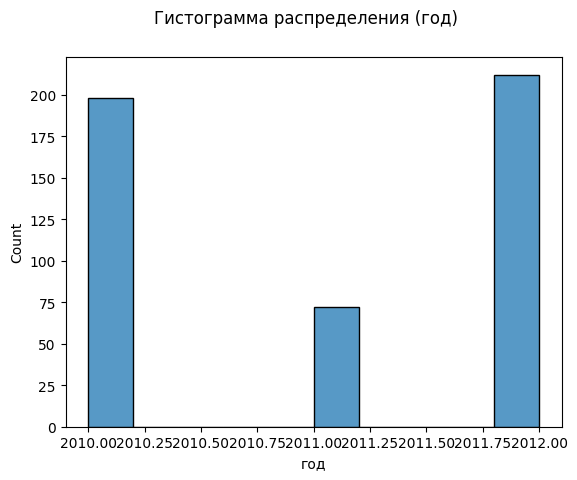

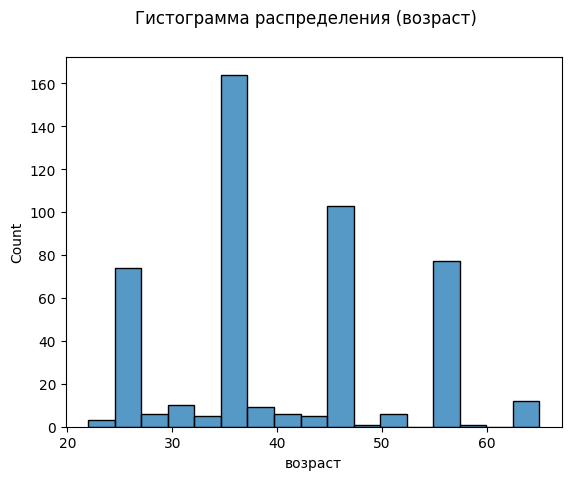

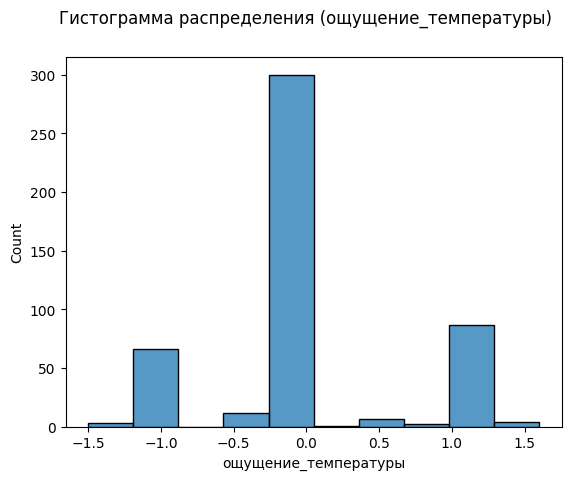

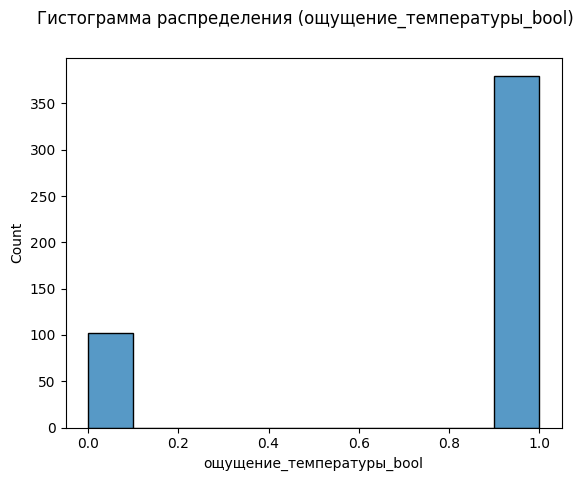

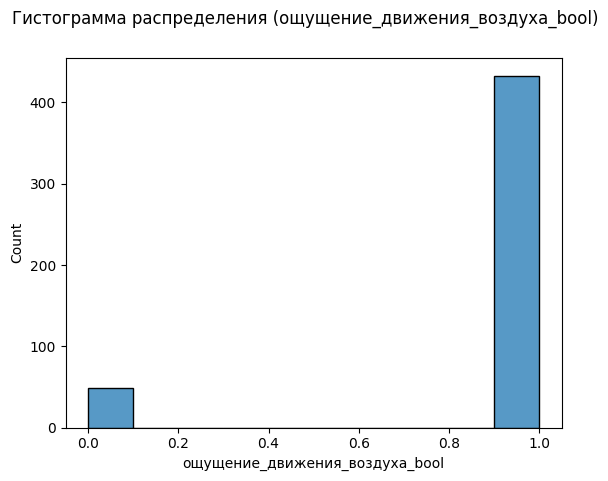

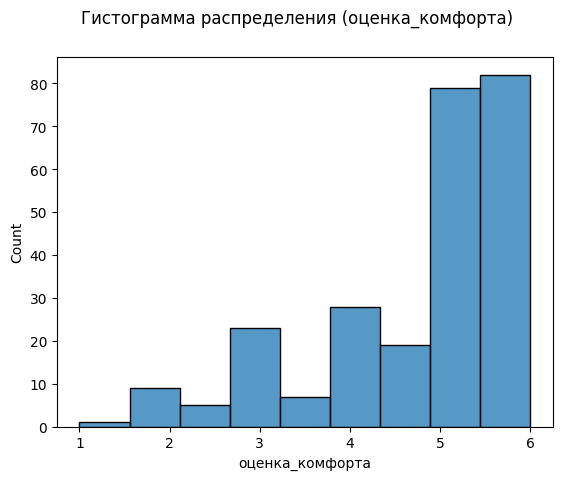

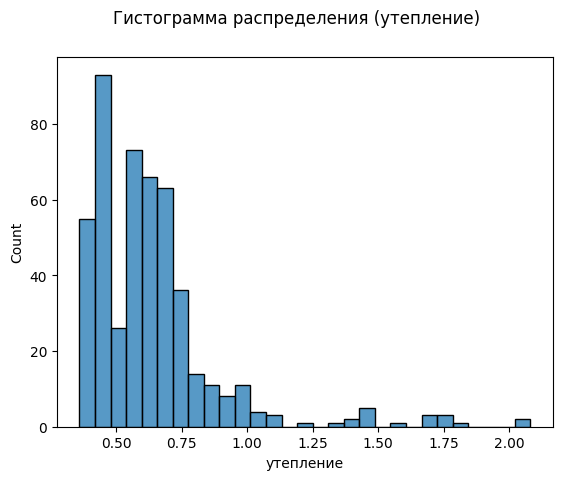

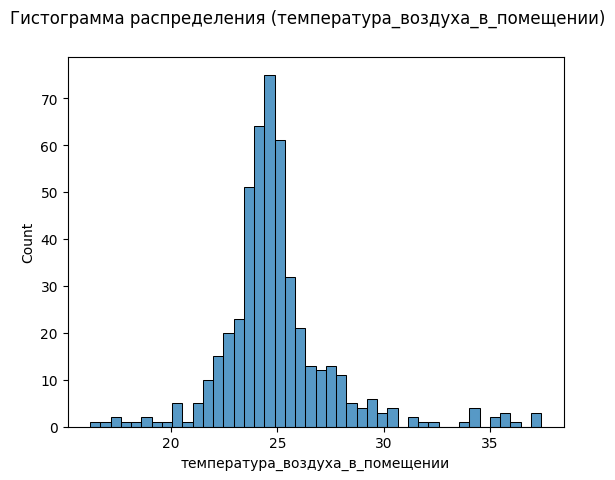

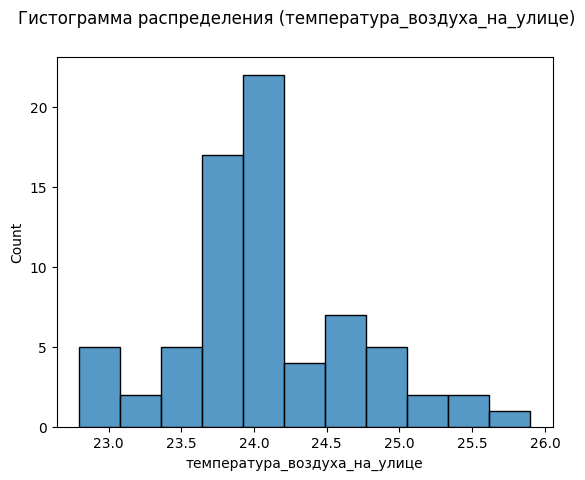

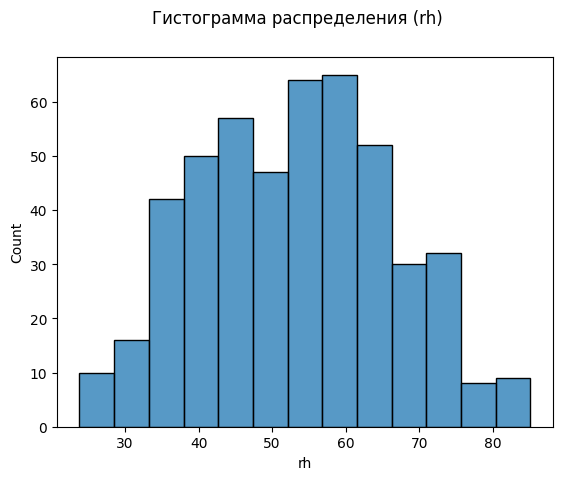

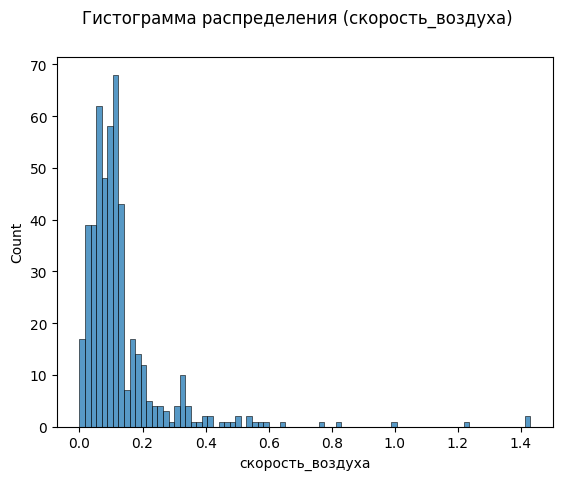

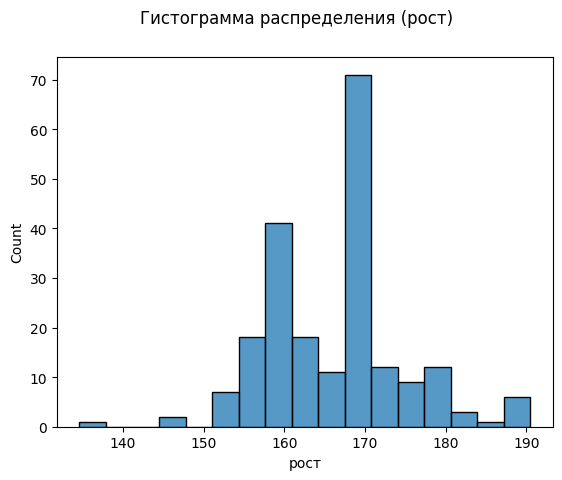

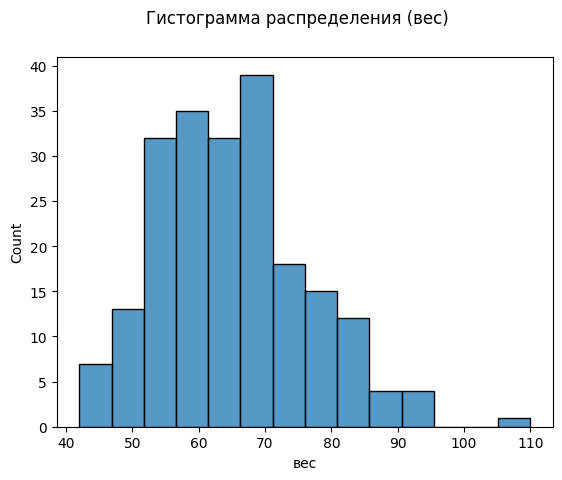

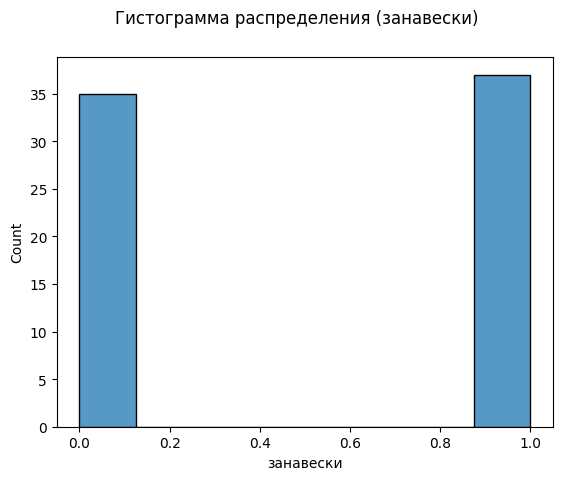

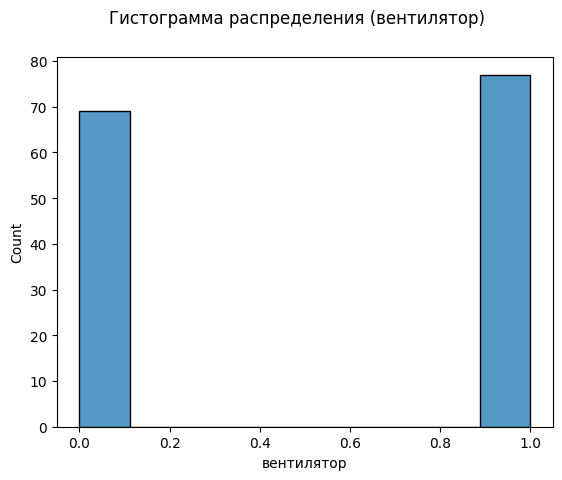

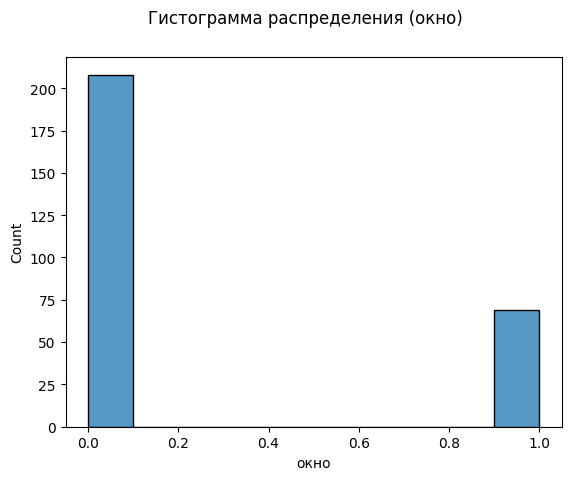

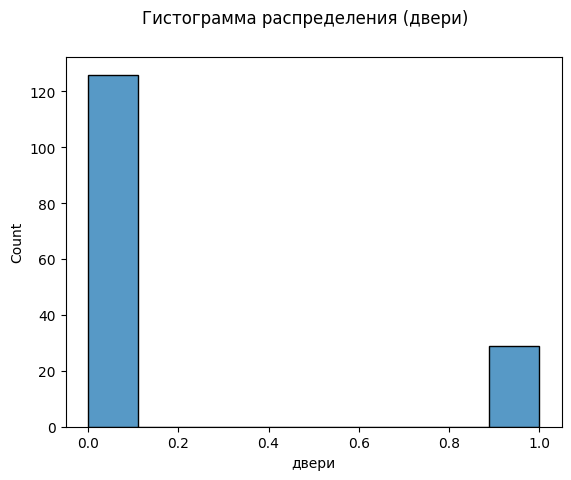

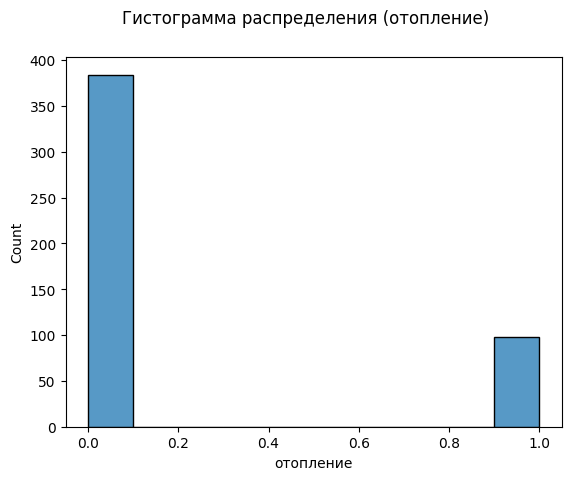

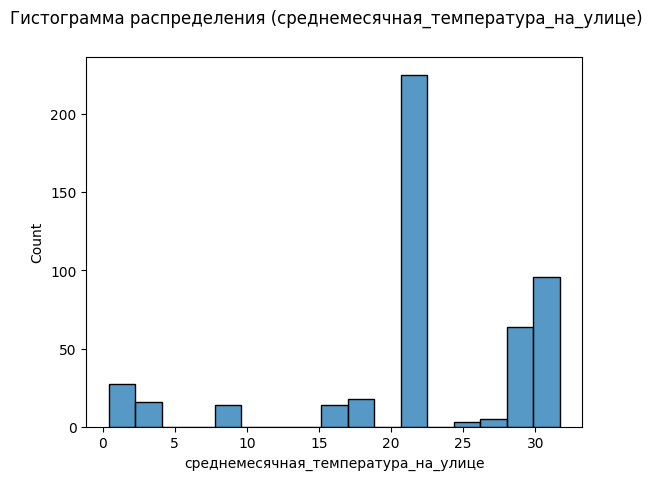

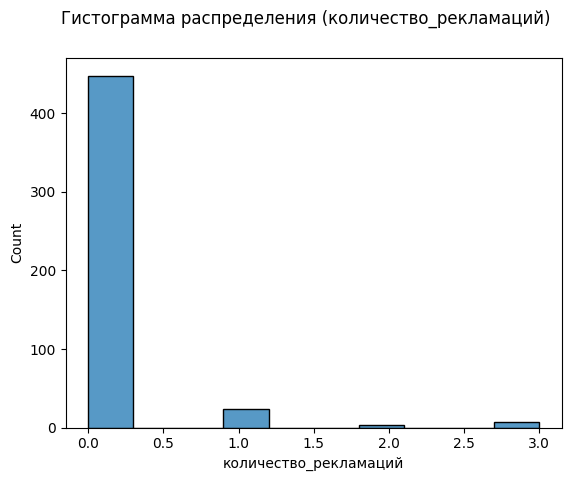



Описание категориальных данных:


,count,unique,top,freq
время_года,482,4,Лето,372
климат,482,5,Субтропический океанический,270
город,482,8,Сидней,198
страна,482,3,Индия,212
способ_охлаждения,482,3,Смешанный,335
режим_при_смешанном_типе_охлаждения,335,2,Кондиционирование,235
способ_обогрева,222,1,Механическое отопление,222
пол,410,2,Мужской,254
предпочтительное_изменение_температуры,482,3,Без изменений,288
предпочтительное_изменение_движения_воздуха,482,3,Без изменений,291



Графическое представление категориальных данных:


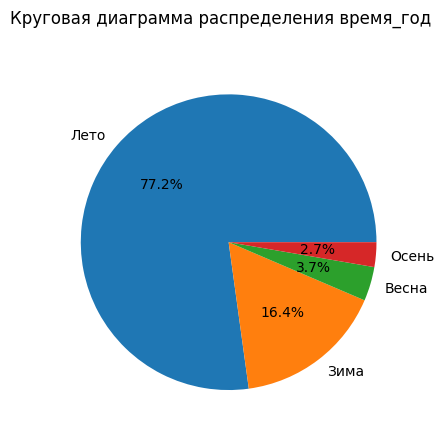

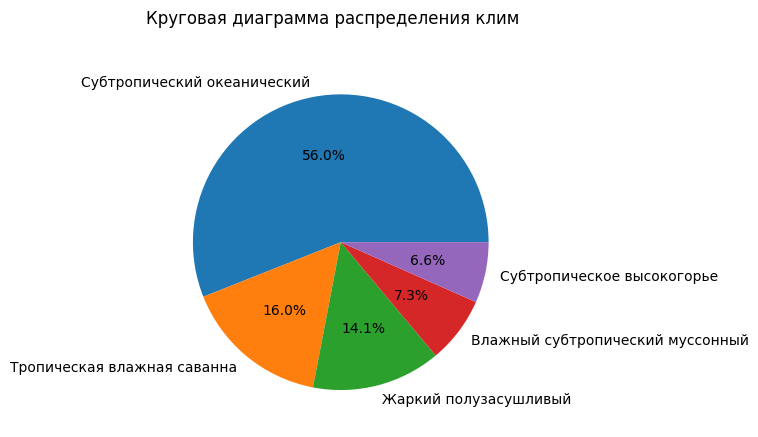

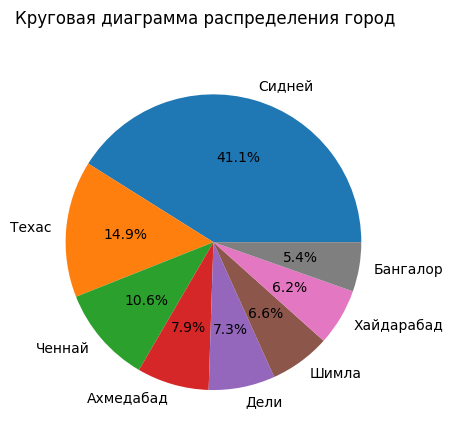

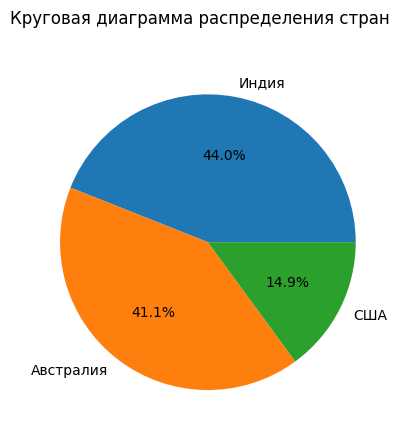

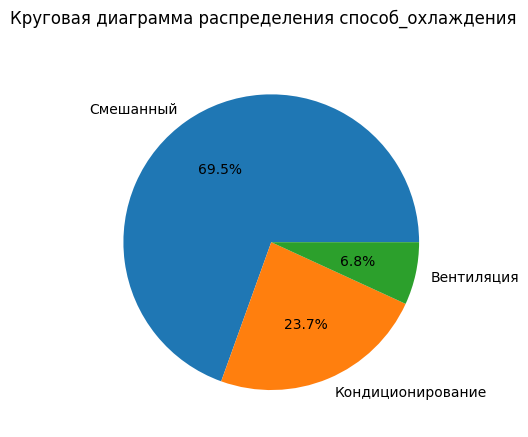

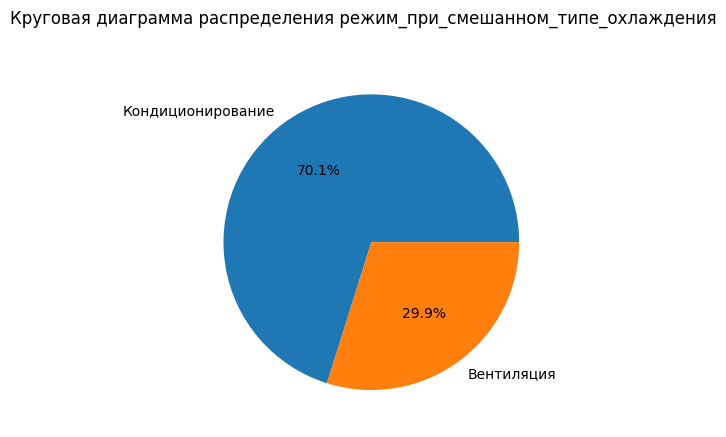

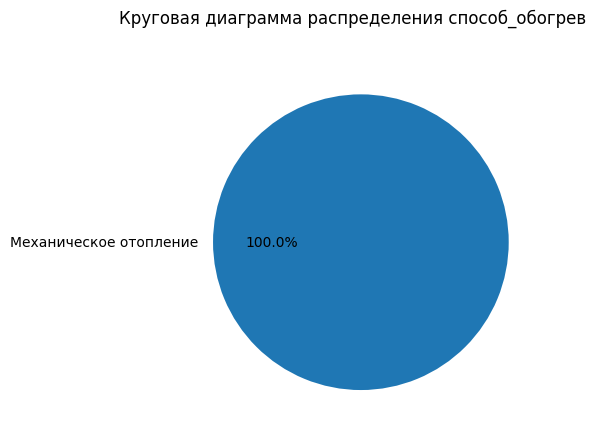

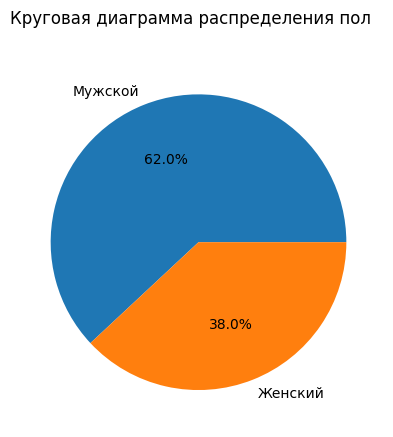

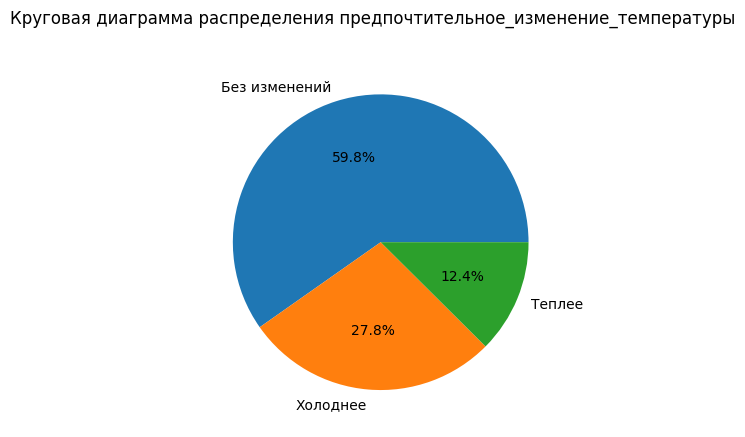

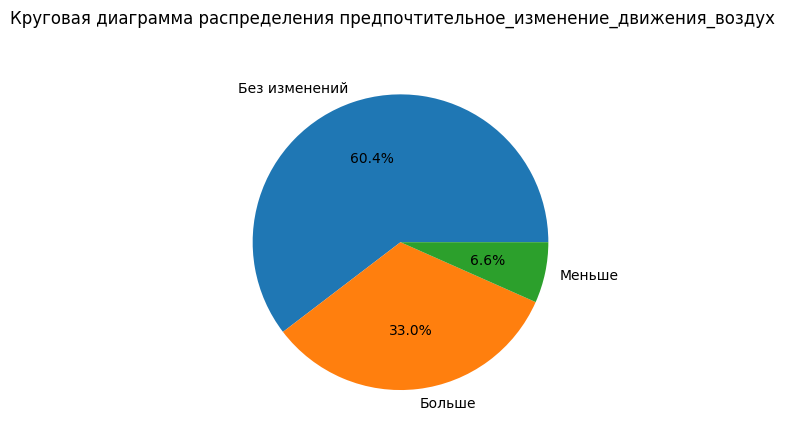

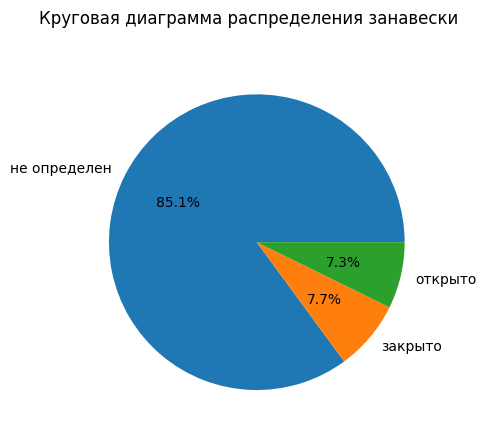

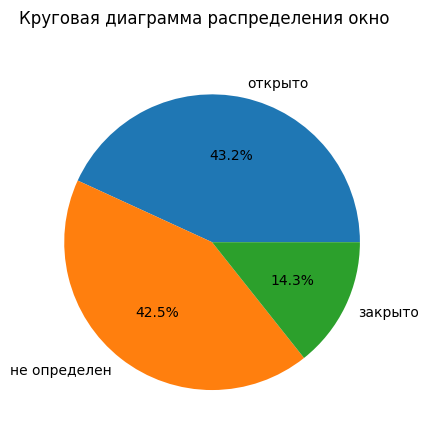

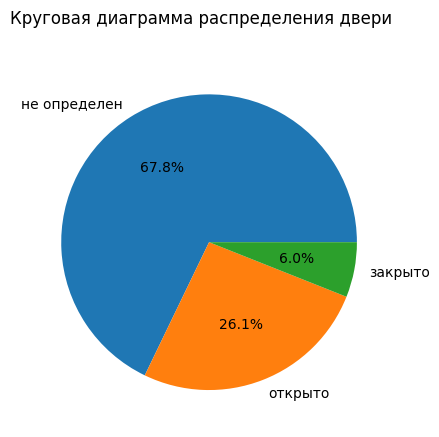

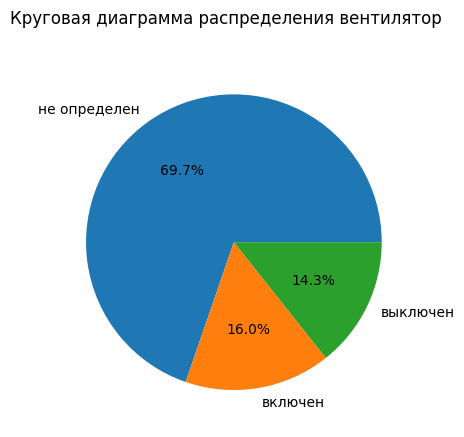

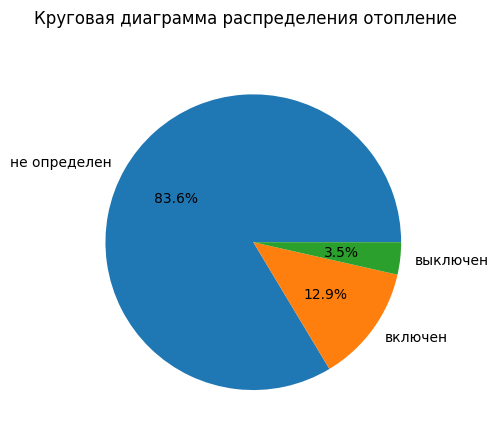

In [153]:
check_data(df)

Благодаря проделанной нами работы наши данные были очищены от дубликатов, были заполнены пропуски в столбцах, где это было нужно, а также устранены выбросы, мешающие корректному анализу данных. Данные были приведены в порядок. Мы можем продолжать дальнейшую работу.

## Расчёты

+ Создадим дополнительный категориальный столбец, который покажет количество рекламаций по каждому клиенту отдельно: мало (≤1), средне (=2), много (>2).
+ Рассчитаем средний возраст респондентов по полу и стране, чтобы понимать целевую аудиторию.
+ Добавим категориальный столбец, разделив респондентов на три категории по возрасту: до 44 лет - молодой возраст, 45 - 59 лет - средний возраст, 60 лет и больше - пожилой возраст.
+ Рассчитаем среднюю комфортную температуру в зависимости от возрастной категории, чтобы понять потребности клиента.
+ Рассчитаем медианное значение температуры и влажности для каждого типа охлаждения, чтобы посмотреть как тип охлаждения влияет на эти факторы.
+ Добавим столбец с процентом удовлетворенных респондентов температурой воздуха в помещении относительно всех респондентов одной страны и одного пола

In [154]:
# создаем дополнительный категориальный столбец, который покажет количество рекламаций по каждому клиенту
df['колво_рекламаций_катег'] = df['количество_рекламаций'].apply(kolvo_complaints_cat)
# рассчитываем средний возраст респондентов по полу и стране
average_age_groupby_gender_country = df.groupby(['пол', 'страна'])['возраст'].mean().round(4)

In [155]:
average_age_groupby_gender_country

пол      страна   
Женский  Австралия    46.3483
         Индия        36.0448
Мужской  Австралия    42.6147
         Индия        37.2759
Name: возраст, dtype: float64

In [156]:
# рассчитаем медианное значение температуры и влажности для каждого типа охлаждения
median_temp_humidity_for_type_of_cooling = df.groupby('способ_охлаждения')[['температура_воздуха_в_помещении', 'rh']].median().round(4)

In [157]:
median_temp_humidity_for_type_of_cooling

,температура_воздуха_в_помещении,rh
способ_охлаждения,,
Вентиляция,25.3000,46.30
Кондиционирование,24.2778,42.45
Смешанный,24.6000,56.50


In [158]:
# добавление нового столбца который категоризирует возраст
df['возраст_кат'] = df['возраст'].apply(age_category)
# рассчитаем среднюю комфортную температуру в зависимости от возрастной категории
average_comfortable_temp_groupby_agecat = df[df['ощущение_температуры_bool'] == 1].groupby(['возраст_кат'])['температура_воздуха_в_помещении'].mean().round(4)

In [159]:
average_comfortable_temp_groupby_agecat

возраст_кат
молодой возраст    25.1604
пожилой возраст    25.4000
средний возраст    24.1117
Name: температура_воздуха_в_помещении, dtype: float64

In [160]:
# добавим столбец с процентом удовлетворенных респондентов температурой воздуха в помещении относительно всех респондентов одной страны и одного пола
df['процент_удовлетворенных_температурой'] = (df.groupby(['страна', 'пол'])['ощущение_температуры_bool'].transform('mean') * 100).round(1)

Создадим новый категориальный столбец, в котором будет показано, удовлетворяет ли зафиксированная относительная влажность стандарту или нет. Категории назначить самостоятельно.

In [161]:
# Применим к столбцу 'rh' (относительная влажность)
df['категория_влажности'] = df['rh'].apply(cat_hum)

# Проверим результат
print(df['категория_влажности'].value_counts())

категория_влажности
комфортная_влажность    321
высокая_влажность       149
низкая_влажность         12
Name: count, dtype: int64


Составим сводную таблицу, в которой данные будут сгруппированы по стране, полу, возрастной группе и подсчитаны средняя температура воздуха в помещении, на улице и средняя относительная влажность для каждой из этих групп.

In [162]:
index = ['страна', 'пол', 'возраст_кат']
values = ['температура_воздуха_в_помещении', 'температура_воздуха_на_улице', 'rh']
pd.pivot_table(df, index=index, values=values, aggfunc='mean').round(4)

rh  температура_воздуха_в_помещении
страна    пол     возраст_кат                                              
Австралия Женский молодой возраст  61.3680                          23.8400
                  пожилой возраст  44.5500                          24.9000
                  средний возраст  61.2661                          24.1125
          Мужской молодой возраст  61.6689                          24.1467
                  пожилой возраст  64.3667                          24.7333
                  средний возраст  61.6803                          24.0443
Индия     Женский молодой возраст  49.8865                          26.6673
                  средний возраст  49.9400                          24.2333
          Мужской молодой возраст  49.5420                          25.9780
                  пожилой возраст  78.8000                          29.3000
                  средний возраст  52.7614                          26.1886

## Исследование корреляций 

Проведем корреляционный анализ для связи столбцов: количественная-количественная

In [163]:
factors = df.select_dtypes(exclude=[object, bool]).columns[1:]
answer = []
for i in range(len(factors) - 1):
    for j in range(i + 1, len(factors)):
        dt1 = df[factors[i]]
        dt2 = df[factors[j]]
        if shapiro(dt1)[1] >= 0.05 and shapiro(dt2)[1] >= 0.05:
            if float(round(pearsonr(dt1, dt2)[1], 4)) < 0.05:
                answer.append([factors[i], factors[j],
                               float(round(pearsonr(dt1, dt2)[0], 2)),
                               'Пирсон'])
        else:
            if float(round(spearmanr(dt1, dt2)[1], 4)) < 0.05:
                answer.append([factors[i], factors[j],
                               float(round(spearmanr(dt1, dt2)[0], 2)),
                               'Спирмен'])
answer = sorted(answer, key=lambda x: -x[2])
answer = pd.DataFrame(answer)
answer.columns = [e for e in ['показатель_1', 'показатель_2', 'значение_корреляции', 'метод_корреляции']]
answer.head(20)

,показатель_1,показатель_2,значение_корреляции,метод_корреляции
0,утепление,отопление,0.50,Спирмен
1,скорость_воздуха,среднемесячная_температура_на_улице,0.32,Спирмен
2,температура_воздуха_в_помещении,среднемесячная_температура_на_улице,0.25,Спирмен
3,температура_воздуха_в_помещении,скорость_воздуха,0.20,Спирмен
4,утепление,температура_воздуха_в_помещении,0.19,Спирмен
5,возраст,rh,0.17,Спирмен
6,ощущение_температуры,rh,0.13,Спирмен
7,скорость_воздуха,количество_рекламаций,0.12,Спирмен
8,утепление,количество_рекламаций,0.11,Спирмен
9,ощущение_температуры,отопление,-0.09,Спирмен


Проведем корреляционный анализ для связи столбцов: категориальная-категориальная

Используем метод Kрамера

In [164]:
factors = df.select_dtypes(include=[object, bool]).columns
answer = []
for i in range(len(factors) - 1):
    for j in range(i + 1, len(factors)):
        dt1 = df[factors[i]]
        dt2 = df[factors[j]]
        cramer = my_cramers(dt1, dt2)
        answer.append([factors[i], factors[j], float(round(cramer, 4))])
answer = sorted(answer, key=lambda x: -x[2])
answer = pd.DataFrame(answer)
answer.columns = [e for e in ['показатель_1', 'показатель_2', 'значение_корреляции']]
answer.head(20)

,показатель_1,показатель_2,значение_корреляции
0,климат,город,1.0000
1,город,страна,1.0000
2,город,способ_охлаждения,0.7151
3,климат,страна,0.7071
4,город,занавески_кат,0.7071
5,страна,занавески_кат,0.7071
6,занавески_кат,вентилятор_кат,0.6704
7,город,вентилятор_кат,0.6123
8,страна,способ_охлаждения,0.5981
9,город,двери_кат,0.5579


Нас интересует в какой тип климатического оборудовани вкладывать. Для этого проведем корреляционный анализ для связи столбцов: категориальная-количественная.

Используем Eta для расчета

In [165]:
answer = []
factors = df.select_dtypes(exclude=object).columns
target = 'способ_охлаждения'
for el in factors:
    answer.append([target, el, correlation_ratio(df[target], df[el])])
answer = sorted(answer, key=lambda x: -x[2])
answer = pd.DataFrame(answer)
answer.columns = [e for e in ['показатель_1', 'показатель_2', 'значение_корреляции']]
answer

,показатель_1,показатель_2,значение_корреляции
0,способ_охлаждения,год,0.3801
1,способ_охлаждения,возраст,0.3560
2,способ_охлаждения,rh,0.3453
3,способ_охлаждения,отопление,0.2815
4,способ_охлаждения,утепление,0.2660
5,способ_охлаждения,количество_рекламаций,0.2232
6,способ_охлаждения,ощущение_движения_воздуха_bool,0.2228
7,способ_охлаждения,скорость_воздуха,0.1551
8,способ_охлаждения,ощущение_температуры,0.1243
9,способ_охлаждения,температура_воздуха_в_помещении,0.1118


Построим матрицу корреляций для наглядности и сделаем выводы, какие факторы коррелируют и что это может нам дать.

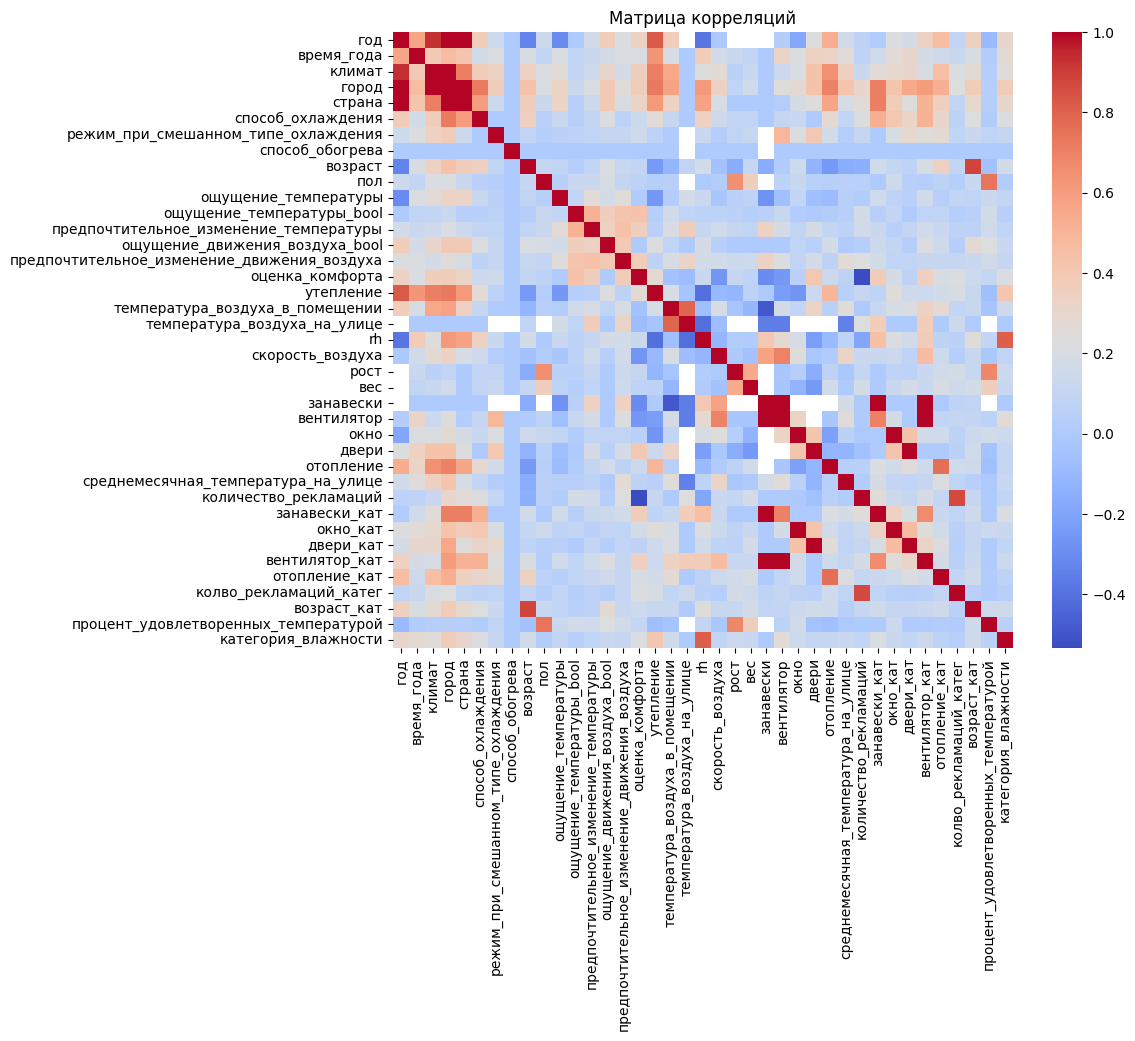

In [167]:
plt.figure(figsize=(10, 8))
corr_df = pd.DataFrame(index=df.columns, columns=df.columns)
for col1 in df.columns:
    for col2 in df.columns:
        if col1 == col2:
            corr_df.loc[col1, col2] = 1.0
        else:
            if df[col1].dtype in ('int64', 'float64') and df[col2].dtype in ('int64', 'float64'):
                dt1 = df[col1]
                dt2 = df[col2]
                if shapiro(dt1)[1] >= 0.05 and shapiro(dt2)[1] >= 0.05:
                    corr_df.loc[col1, col2] = df[[col1, col2]].corr().iloc[0, 1]
                else:
                    corr_df.loc[col1, col2] = df[[col1, col2]].corr(method='spearman').iloc[0, 1]
            elif df[col1].dtype in ['object', 'bool'] and df[col2].dtype in ['object', 'bool']:
                dt1 = df[col1]
                dt2 = df[col2]
                cramer = my_cramers(dt1, dt2)
                corr_df.loc[col1, col2] = round(cramer, 2)
            else:
                g = df.dropna(subset=[col1, col2])
                if df[col1].dtype in ['object', 'bool']:
                    corr_df.loc[col1, col2] = correlation_ratio(g[col1], g[col2])
                elif df[col2].dtype in ['object', 'bool']:
                    corr_df.loc[col1, col2] = correlation_ratio(g[col2], g[col1])

for col in corr_df.columns:
    corr_df[col] = corr_df[col].astype('float64')
sns.heatmap(corr_df, cmap='coolwarm')
plt.title('Матрица корреляций')
plt.show()


#### Выводы по корреляциям

+ Факторы, которые коррелируют благодаря географическим особенностям: страна, город, климат, среднемесячная температура, относительная влажность, движение воздуха.
+ Также к этим фактором можно отнести утепление: оно зависит от того, в какой местности ты проживаешь. Наша матрица показывает, что чем хуже оценивают температуру люди, тем больше они "утепляются".
+ Наличие отопления зависит от местности, где проживают респонденты.
+ На температуру в помещении влияют следующие факторы: климат, город, страна, среднемесячная температура на улице, относительная влажность.
+ На оценку комфорта влияют следующие факторы: изменение движения воздуха и ощущение температуры, а также количество рекламаций. 
+ На факт, какой способ охлаждения выбирают клиенты влияют географические особенности. Еще мы можем увидеть зависимость от того, используют ли пользователи естественную вентиляцию или нет. Влажность в помещении таже важна для выбора способа охлаждения.

Все остальные зависимости не дают четкой картины, поэтому продолжим наше исследование и перейдем к гипотезам.

## Проверка гипотез

### Гипотезы, выдвинутые руководством

#### Влияет ли способ охлаждения на оценку комфорта? категориальная - количественная. 3 группы

In [168]:
df.groupby('способ_охлаждения')['оценка_комфорта'].count()

способ_охлаждения
Вентиляция            33
Кондиционирование    114
Смешанный            106
Name: оценка_комфорта, dtype: int64

In [169]:
conclusion(*testing_statistical_hypotheses(df, columns=['способ_охлаждения', 'оценка_комфорта']))

'Метод: Краскела–Уоллиса, stat: 6.543, p-value: 0.0379, ✅ Различия в оценке комфорта между группами статистически значимы.'

Стоит отметить тот факт, что чем больше статистическое значение при этом методе, тем больше различий между нашими группами. Нужно помнить об этом. Рассчитаем p-value для наших групп, чтобы проверить это.

In [170]:
pvals, comparisons = pairwise_comparison_mannwhitn('способ_охлаждения', 'оценка_комфорта')
print("Попарные сравнения ")
for comp, p_adj in zip(comparisons, pvals):
    print(f"{comp}: p = {p_adj:.4f}")

Попарные сравнения 
Вентиляция vs Кондиционирование: p = 0.0310
Вентиляция vs Смешанный: p = 0.1245
Кондиционирование vs Смешанный: p = 0.0813


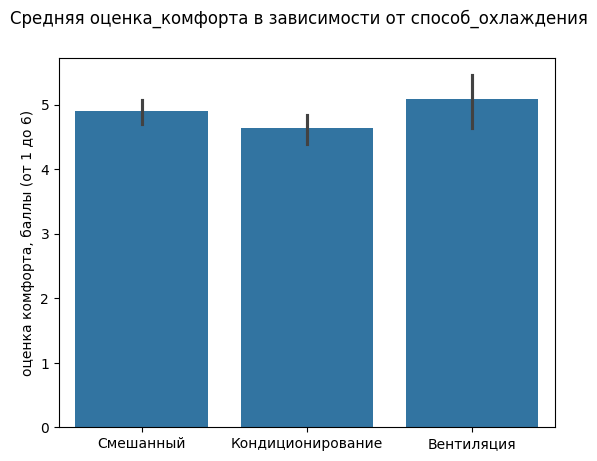

In [171]:
sns.barplot(df, x='способ_охлаждения', y='оценка_комфорта')
plt.xlabel('')
plt.ylabel('оценка комфорта, баллы (от 1 до 6)')
plt.suptitle('Средняя оценка_комфорта в зависимости от способ_охлаждения')
plt.show()

Делаем вывод что оценка комфорта различается при разных типах охлаждения. Лидирующие позиции занимает вентиляция. Работу при смешанном типе охлаждения рассмотрмм в гипотезах, выдвинутых нашей командой.

#### Влияет ли пол на оценку комфорта? категориальная - количественная. 2 группы

In [172]:
df.groupby('пол')['оценка_комфорта'].count()

пол
Женский     59
Мужской    122
Name: оценка_комфорта, dtype: int64

In [173]:
print(conclusion(*testing_statistical_hypotheses(df, columns=['пол', 'оценка_комфорта'], values=['Мужской', 'Женский'])))

Метод: Манн-Уитни, stat: 4037.0, p-value: 0.1695, 🚫 Различий в комфорте между группами не выявлено.


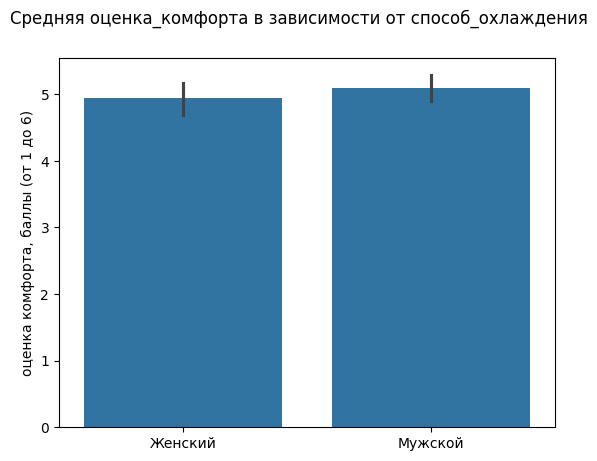

In [174]:
sns.barplot(df, x='пол', y='оценка_комфорта')
plt.xlabel('')
plt.ylabel('оценка комфорта, баллы (от 1 до 6)')
plt.suptitle('Средняя оценка_комфорта в зависимости от способ_охлаждения')
plt.show()

In [175]:
# делаем вывод что пол не влияет на оценку комфорта

#### Влияет ли возрастная группа на оценку комфорта? категориальная - количественная. 3 группы (станет 2)

In [176]:
df.groupby('возраст_кат')['оценка_комфорта'].count()

возраст_кат
молодой возраст    181
пожилой возраст      1
средний возраст     71
Name: оценка_комфорта, dtype: int64

In [177]:
# людей входящий в пожилой_возраст всего 1, опустим эту категорию

In [178]:
conclusion(*testing_statistical_hypotheses(df, columns=['возраст_кат', 'оценка_комфорта'], values=['молодой возраст', 'средний возраст']))

'Метод: Краскела–Уоллиса, stat: 6.543, p-value: 0.0379, ✅ Различия в оценке комфорта между группами статистически значимы.'

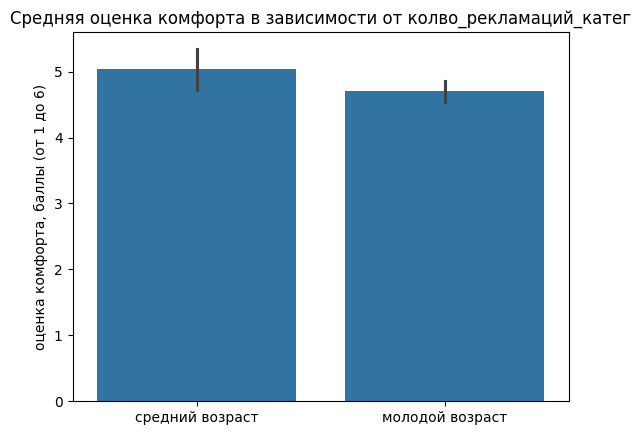

In [179]:
sns.barplot(data=df[df['возраст_кат'] != 'пожилой возраст'], x='возраст_кат', y='оценка_комфорта')
plt.xlabel('')
plt.ylabel('оценка комфорта, баллы (от 1 до 6)')
plt.title('Средняя оценка комфорта в зависимости от колво_рекламаций_катег')
plt.show()

In [180]:
# делаем вывод что оценка комфорта различается для разных возрастных групп

#### Есть ли взаимосвязь между количеством рекламаций и оценкой комфорта? категориальная - количественная. 3 группы

In [181]:
df.groupby('колво_рекламаций_катег')['оценка_комфорта'].count()

колво_рекламаций_катег
мало      245
много       5
средне      3
Name: оценка_комфорта, dtype: int64

In [182]:
conclusion(*testing_statistical_hypotheses(df=df, columns=['колво_рекламаций_катег', 'оценка_комфорта']))

'Метод: Краскела–Уоллиса, stat: 6.543, p-value: 0.0379, ✅ Различия в оценке комфорта между группами статистически значимы.'

In [183]:
pvals, comparisons = pairwise_comparison_mannwhitn('колво_рекламаций_катег', 'оценка_комфорта')
print("Попарные сравнения")
for comp, p_adj in zip(comparisons, pvals):
    print(f"{comp}: p = {p_adj:.4f}")

Попарные сравнения
мало vs много: p = 0.0219
мало vs средне: p = 0.0148
много vs средне: p = 0.4240


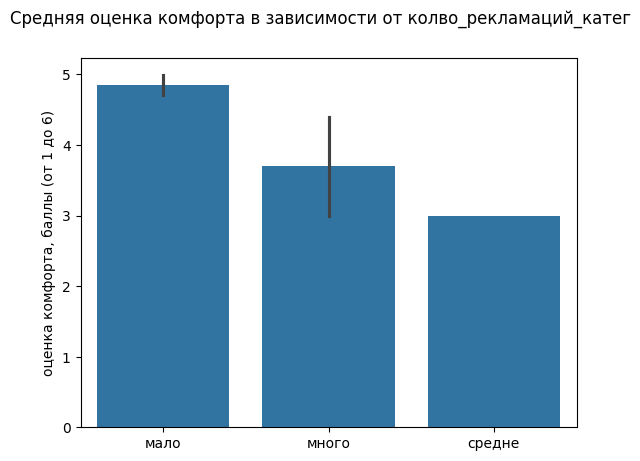

In [184]:
sns.barplot(df, x='колво_рекламаций_катег', y='оценка_комфорта')
plt.xlabel('')
plt.ylabel('оценка комфорта, баллы (от 1 до 6)')
plt.suptitle('Средняя оценка комфорта в зависимости от колво_рекламаций_катег')
plt.show()

In [185]:
# делаем вывод что кол-во рекламаций влияет на оценку комфорта. Чем меньше рекламаций, тем лучше оценка - все просто.

####  Cредняя оценка комфорта отличается в зависимости от страны?

Для начала мы знаем, что у страны Австралии полностью отсутствуют данные оценка_комфорта, и у страны также Индия некоторые пропуски

оценка_комфорта

США Кол-во не пустых значений: 72, Австралия Кол-во не пустых значений: 0, Индия Кол-во не пустых значений: 212,

Так что будем смотреть оценку комфорта только у Индии и США

In [186]:
# давайте проверим сначала статическим методом, а потом графически

# Выделим данные по странам
g1 = df[df['страна'] == 'США']['оценка_комфорта'].dropna()
g2 = df[df['страна'] == 'Индия']['оценка_комфорта'].dropna()

# Проверка на нормальность
_,  pv1 = shapiro(g1)
_,  pv2 = shapiro(g2)
print('Shapiro p1 =', round(pv1, 4), 'p2 =', round(pv2, 4))  

# Данные не распределнны нормально так что используем Mann–Whitney
stat, pv = mannwhitneyu(g1, g2, alternative='two-sided')
print(stat, 'Mann–Whitney =', round(pv, 5))
# Разница в оценке комфорта между странами статистически значима.

Shapiro p1 = 0.0011 p2 = 0.0
3738.0 Mann–Whitney = 0.0


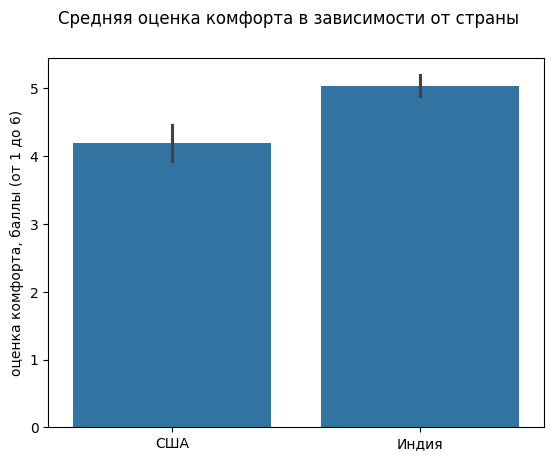

In [187]:
df_filt = df[df['страна'] != 'Австралия'][['страна', 'оценка_комфорта']].dropna()
# Рисуем график по стране и средней оценки 
sns.barplot(df_filt, x='страна', y='оценка_комфорта')
plt.xlabel('')
plt.ylabel('оценка комфорта, баллы (от 1 до 6)')
plt.suptitle('Средняя оценка комфорта в зависимости от страны')
plt.show()

ВЫВОД Средняя оценка отличается в зависимости от страны

### Гипотезы, выдвинутые нашей командой

Наша команда заинтересована в поднятии оценки комфорта, потому все наши исследования мы посвятим именно этому.

#### Взаимосвязаны ли относительная влажность в помещении и оценка комфорта?

In [188]:
# Анализ Индии
analize(df, 'Индия')
# У Австралии и США мало информации, поэтому не будем смотреть

Страна: Индия
высокая_влажность - Shapiro p = 0.0
комфортная_влажность - Shapiro p = 0.0
низкая_влажность - Shapiro p = 0.0021
Краскела Уолеса p = 0.22


Давайте нарисуем график:

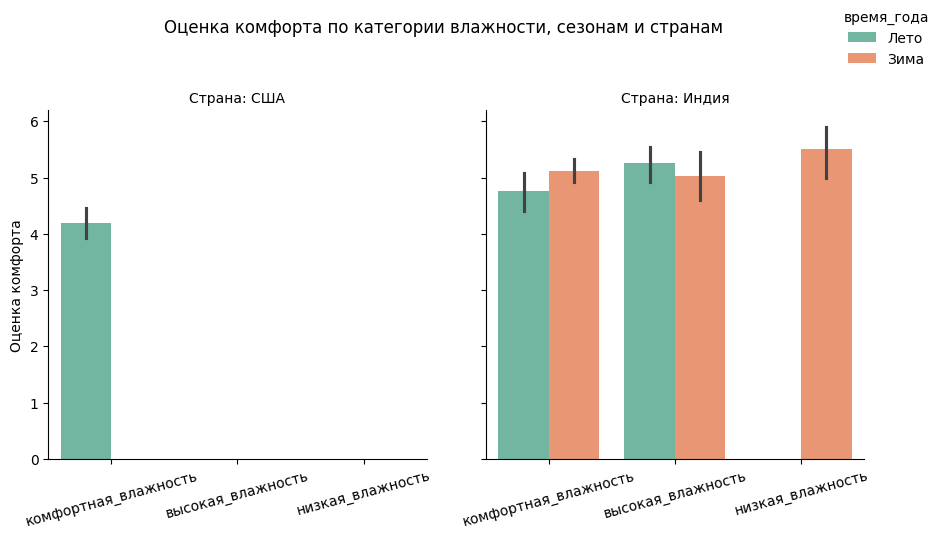

In [189]:
# Фильтруем датафрейм, убираем значения с временами года Весна и Лето, также убираем страну Австралия, так как по ним нет информации
df_filt = df[(df['время_года'] != 'Весна') & (df['время_года'] != 'Осень') & (df['страна'] != 'Австралия')]

# Строим boxplot с фасетами по странам
g = sns.catplot(
    data=df_filt,
    x='категория_влажности',
    y='оценка_комфорта',
    hue='время_года',
    col='страна',
    kind='bar',
    palette='Set2',
    height=5,
    aspect=0.8
)

g.set_axis_labels('', 'Оценка комфорта')
g.set_titles("Страна: {col_name}")
g.fig.suptitle('Оценка комфорта по категории влажности, сезонам и странам', y=1.05)
g.legend.set_bbox_to_anchor((1.05, 1))

# Повернуть подписи на оси X
for ax in g.axes.flat:
    ax.tick_params(axis='x', rotation=15)
    
plt.tight_layout()
plt.show() 

ВЫВОД Так как pvalue > 0.05, значит нет значимой связи, люди в среднем чувствуют себя одинаково при разных уровнях влажности.

#### Взаимосвязны ли оценка комфорта и скорость воздуха?

In [190]:
df_clear = df[['скорость_воздуха', 'оценка_комфорта']].dropna()
gr1 = df_clear['скорость_воздуха']
gr2 = df_clear['оценка_комфорта']
if shapiro(gr1)[1] >= 0.05 and shapiro(gr2)[1] >= 0.05:
    corr, p_val = pearson(gr1, gr2)
    method = 'Pearson'
else:
    corr, p_val = spearmanr(gr1, gr2)
    method = 'Spearman'
print(conclusion(corr, p_val, method))

Метод: Spearman, stat: -0.2592, p-value: 0.0, ✅ Различия в оценке комфорта между группами статистически значимы.


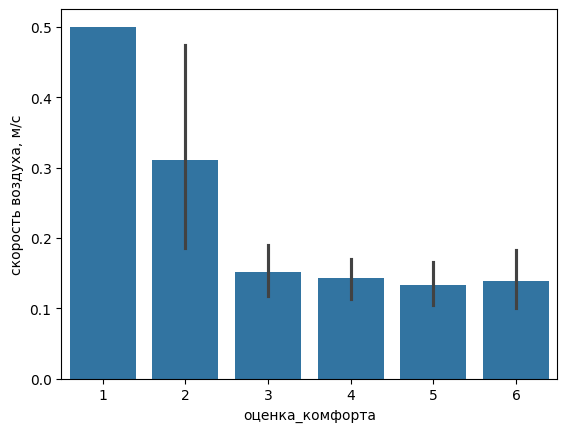

In [193]:
df_for_barplot = df[['оценка_комфорта', 'скорость_воздуха']]
df_for_barplot = df_for_barplot.dropna(subset=['оценка_комфорта'])
df_for_barplot['оценка_комфорта'] = df_for_barplot['оценка_комфорта'].astype(int)
sns.barplot(df_for_barplot, x='оценка_комфорта', y='скорость_воздуха')
plt.ylabel('скорость воздуха, м/c')
plt.show()

Вывод: Чем выше скорость воздуха, тем ниже оценка комфорта

#### Взаимосвязны ли оценка комфорта и режим при смешанном типе охлаждения?

In [194]:
df_clear = df[['режим_при_смешанном_типе_охлаждения', 'оценка_комфорта']].dropna(subset=['оценка_комфорта'])
df_clear['оценка_комфорта'] = df_clear['оценка_комфорта'].astype(int)
print(df_clear.groupby('режим_при_смешанном_типе_охлаждения')['оценка_комфорта'].value_counts())
print(df_clear.groupby('режим_при_смешанном_типе_охлаждения')['оценка_комфорта'].count())

режим_при_смешанном_типе_охлаждения  оценка_комфорта
Вентиляция                           5                  22
                                     6                  16
                                     3                   3
                                     4                   3
                                     2                   2
Кондиционирование                    4                  22
                                     5                  20
                                     6                  12
                                     3                   4
                                     1                   1
                                     2                   1
Name: count, dtype: int64
режим_при_смешанном_типе_охлаждения
Вентиляция           46
Кондиционирование    60
Name: оценка_комфорта, dtype: int64


Исходя из данных полученных раннее, можем сделать вывод что наши данные распределены ненормально

In [195]:
pvals, comparisons = pairwise_comparison_mannwhitn('режим_при_смешанном_типе_охлаждения', 'оценка_комфорта')
for comp, p_adj in zip(comparisons, pvals):
    print(f"{comp}: p_value = {p_adj:.4f}")

Вентиляция vs Кондиционирование: p_value = 0.0121


✅ Различия в оценке комфорта между группами статистически значимы.

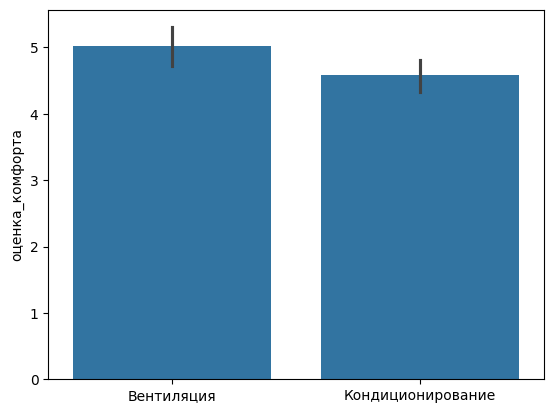

In [196]:
sns.barplot(df_clear, x='режим_при_смешанном_типе_охлаждения', y='оценка_комфорта')
plt.xlabel('')
plt.show()

In [197]:
print('Описательный анализ для оценки комфорта при режиме вентиляция')
print(df[df['режим_при_смешанном_типе_охлаждения'] == 'Вентиляция']['оценка_комфорта'].describe())
print('Описательный анализ для оценки комфорта при режиме кондиционирование')
print(df[df['режим_при_смешанном_типе_охлаждения'] == 'Кондиционирование']['оценка_комфорта'].describe())

Описательный анализ для оценки комфорта при режиме вентиляция
count    46.000000
mean      5.072381
std       1.033327
min       2.000000
25%       5.000000
50%       5.125000
75%       6.000000
max       6.000000
Name: оценка_комфорта, dtype: float64
Описательный анализ для оценки комфорта при режиме кондиционирование
count    60.000000
mean      4.758902
std       1.006917
min       1.000000
25%       4.528409
50%       5.000000
75%       5.125000
max       6.000000
Name: оценка_комфорта, dtype: float64


Вывод: Хоть и данных недостаточно, чтобы точно сказать истинно это или нет, но нас заинтересовал тот факт, что при вентиляции дают такие высокие оценки комфорта(в среднем это что-то между 5 и 6).

#### Взаимосвзяны ли оценка комфорта и климат?

In [198]:
print(conclusion(*testing_statistical_hypotheses(df, columns=['климат', 'оценка_комфорта'])))

Метод: Краскела–Уоллиса, stat: 6.543, p-value: 0.0379, ✅ Различия в оценке комфорта между группами статистически значимы.


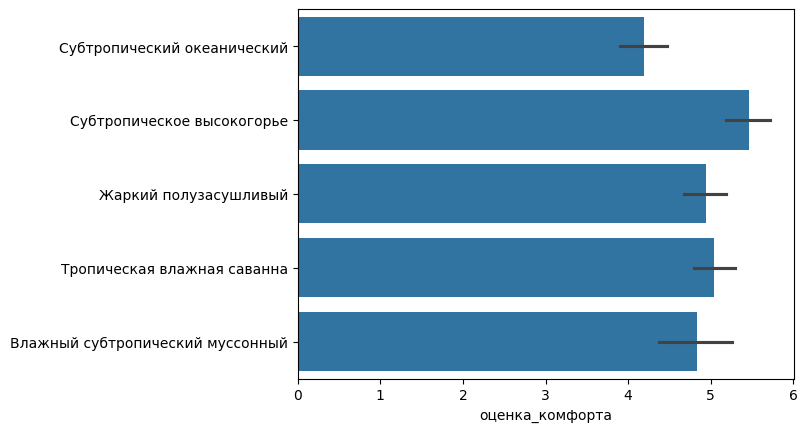

In [199]:
sns.barplot(df, y='климат', x='оценка_комфорта')
plt.ylabel('')
plt.show()

Вывод: Оценка комфорта значимо различается в зависимиости от типа климата

## Регрессионное моделирование

Построить регрессионную модель температуры воздуха в помещении в зависимости от типа охлаждения и других значимых факторов.
Выбор факторов - на усмотрение исполнителя.

In [356]:
# Указываем нужные признаки
# целевая переменная
trt = 'температура_воздуха_в_помещении'

# Список категориальных и числовых признаков
cat_l = ['способ_охлаждения', 'климат', 'время_года', 'вентилятор', 'окно', 'город',
         'предпочтительное_изменение_температуры', 'ощущение_движения_воздуха_bool', 'ощущение_температуры_bool', 'занавески']
num_l = ['среднемесячная_температура_на_улице', 'ощущение_температуры', 'утепление', 'rh']

""" Все эти факторы косвенно влияют на темпераутру воздуха в помещении """
x_train, x_test, y_train, y_test = train_test_split(df[cat_l + num_l], df[trt], test_size=0.15, random_state=42)
# Преобразования категориальных данных в числовой формат
ohe.fit(x_train[cat_l])
x_train = get_ohe(x_train, cat_l)
x_test = get_ohe(x_test, cat_l)
x_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73 entries, 0 to 72
Data columns (total 30 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   среднемесячная_температура_на_улице              73 non-null     float64
 1   ощущение_температуры                             73 non-null     float64
 2   утепление                                        73 non-null     float64
 3   rh                                               73 non-null     float64
 4   способ_охлаждения_Кондиционирование              73 non-null     float64
 5   способ_охлаждения_Смешанный                      73 non-null     float64
 6   климат_Жаркий полузасушливый                     73 non-null     float64
 7   климат_Субтропический океанический               73 non-null     float64
 8   климат_Субтропическое высокогорье                73 non-null     float64
 9   климат_Тропическая влажная саванна

In [357]:
# Обучаем модель
mdl = LinearRegression()
mdl.fit(x_train, y_train)
# Предсказание целевой
pred_test = mdl.predict(x_test)

In [358]:
# Функция выводит метрики качества для регрессионных моделей (точность модели)
metrics_model(y_test, pred_test)

R2 = 0.684
MAPE = 3.797 %
MAE = 0.997
RMSE = 1.379


Вывод, мы построили довольно сильную и точную модель.<br>
R2 = 68% дисперсии объясняется моделью<br>
MAPE = модель в среднем ошибается менее чем на 4% от факта, это отлично<br>
MAE = ошибка в 1 градус - это очень хорошо <br>
RMSE = близко к MAE, значит, нет сильных выбросов. Модель стабильная.

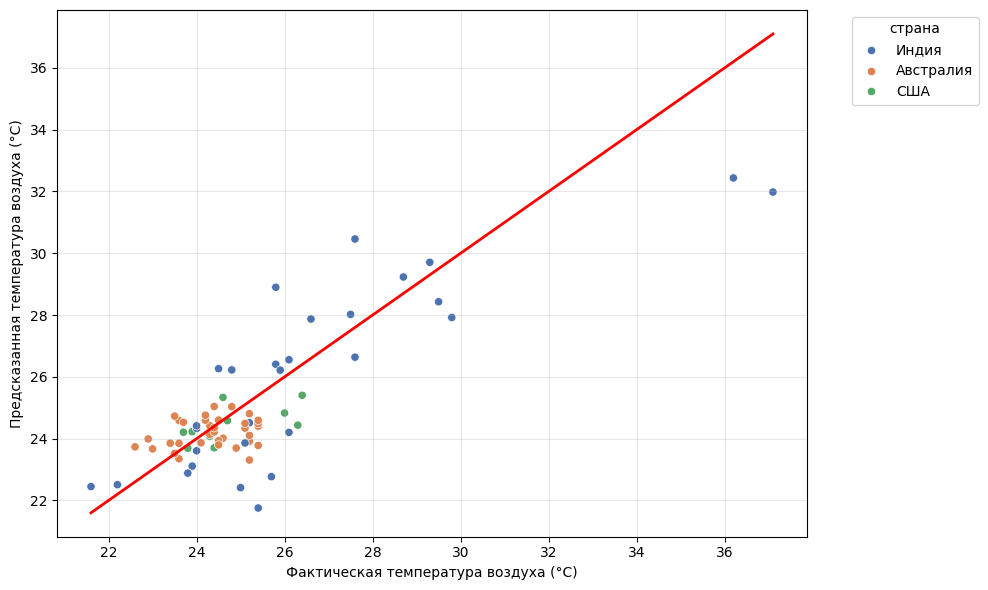

In [359]:
df_plot = pd.DataFrame({
    'Фактическая температура': y_test,
    'Предсказанная температура': pred_test
}).reset_index(drop=True)

category_to_plot = 'страна'  # можно заменить на другую категориальную переменную
df_plot[category_to_plot] = df.loc[y_test.index, category_to_plot].values

plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_plot,
    x='Фактическая температура',
    y='Предсказанная температура',
    hue=category_to_plot,
    palette='deep'
)

plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linewidth=2)

plt.legend(title=category_to_plot, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.xlabel('Фактическая температура воздуха (°C)')
plt.ylabel('Предсказанная температура воздуха (°C)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

По графику видно, что модель в предсказывает неплохо, но есть некоторые недостатки, например:
1) Большинство точек (от 23 до 27 градусов) расположены близко к красной и  это хорошо. 
Значит,в этом диапазоне модель справляется хорошо.
2) Некоторые точки выше линии, это значит, что модель завышает предсказания 
(предсказывает больше, чем есть на самом деле). 
3) Некоторые точки ниже линии, это значит, что занижает.
4) Крайние точки (выбросы), пара значений с фактической температурой выше 30 градусов заметно отклоняются от линии,
для них модель ошибается сильнее. Это случается, если таких примеров было мало в обучающих данных.

ВЫВОД: Модель предсказывает нормально, особенно в основном диапазоне температур.

## Проводим собственные исследования, чтобы выявить оборудование, в которое мы будем вкладывать

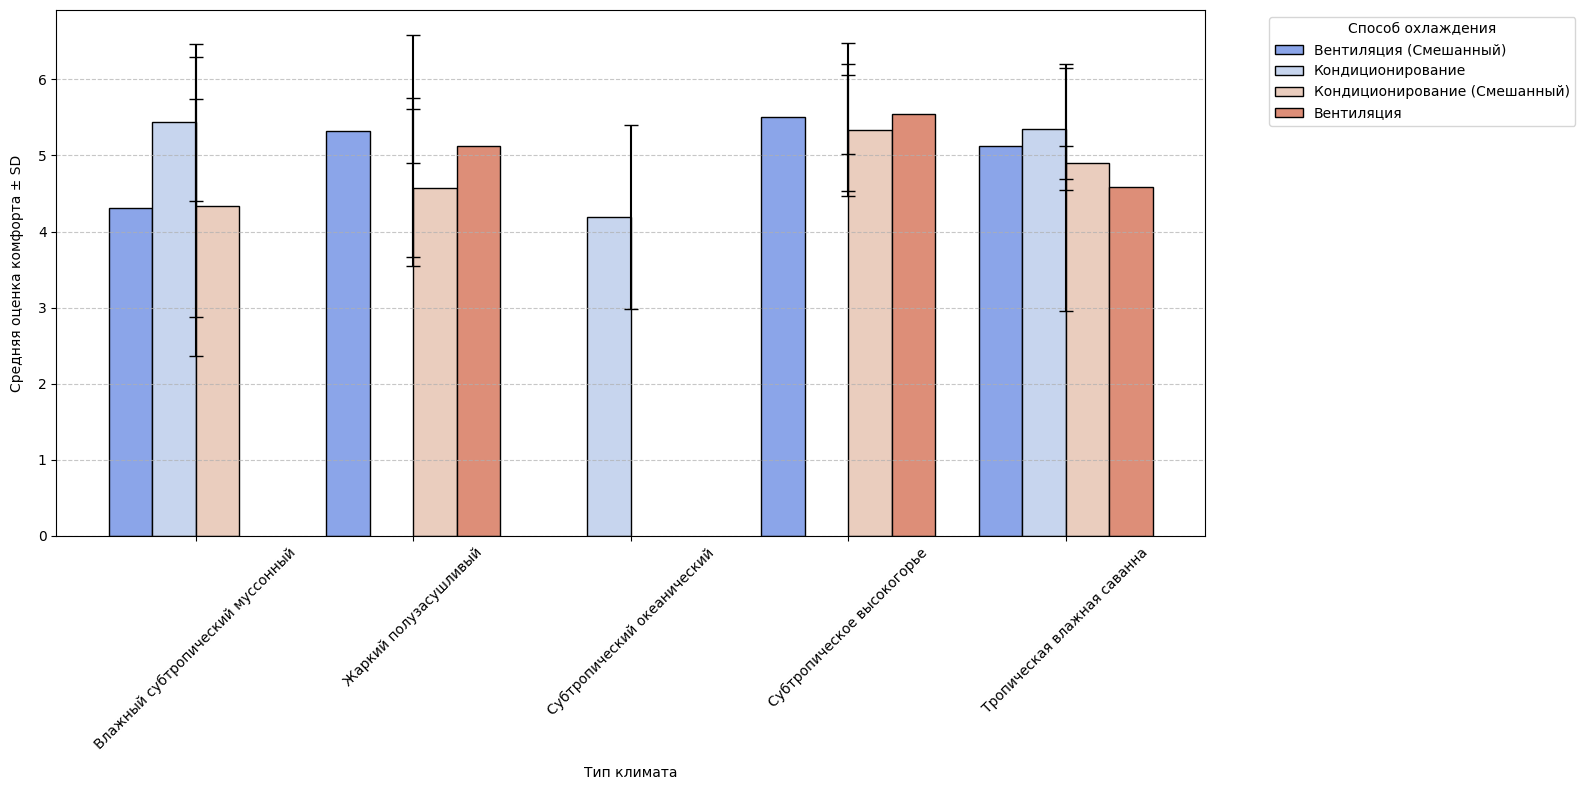


Статистически значимые различия (Манна-Уитни, p-value < 0.05):

Субтропический океанический: недостаточно данных для сравнения (n_вент = 0, n_другие = 72)

Субтропическое высокогорье:
Вентиляция (n=23): Медиана = 6.00, IQR = [5.00, 6.00]
Другие методы (n=9): Медиана = 6.00, IQR = [5.00, 6.00]
U = 115, p-value = 0.597 не значимо

Жаркий полузасушливый:
Вентиляция (n=30): Медиана = 5.12, IQR = [5.12, 6.00]
Другие методы (n=28): Медиана = 4.70, IQR = [4.00, 5.12]
U = 630, p-value = 0.001 ***
✅ Вентиляция дает значимо более высокий комфорт (по медиане)

Тропическая влажная саванна:
Вентиляция (n=13): Медиана = 5.12, IQR = [4.00, 6.00]
Другие методы (n=43): Медиана = 5.00, IQR = [4.70, 6.00]
U = 252, p-value = 0.583 не значимо

Влажный субтропический муссонный:
Вентиляция (n=13): Медиана = 5.00, IQR = [3.00, 5.00]
Другие методы (n=22): Медиана = 6.00, IQR = [5.00, 6.00]
U = 88, p-value = 0.046 *
❌ Вентиляция дает значимо более низкий комфорт (по медиане)

Крускал-Уоллис тест между климатич

In [246]:
# Подготовка данных
df_prep = df.dropna(subset=['оценка_комфорта']).copy()

# Уточнение смешанного типа охлаждения
df_prep.loc[df_prep['способ_охлаждения'] == 'Смешанный', 'способ_охлаждения'] = (
    df_prep['режим_при_смешанном_типе_охлаждения'] + ' (Смешанный)'
)

# Группировка по климату и способу охлаждения
climate_groups = df_prep.groupby(['климат', 'способ_охлаждения'])['оценка_комфорта'].agg(
    ['mean', 'count', 'std', 'sem']
).reset_index()

plt.figure(figsize=(16, 8))
sns.barplot(
    data=climate_groups,
    x='климат',
    y='mean',
    hue='способ_охлаждения',
    palette='coolwarm',
    edgecolor='black'
)

for i, row in climate_groups.iterrows():
    plt.errorbar(
        x=row['климат'],
        y=row['mean'],
        yerr=row['std'],
        fmt='none',
        color='black',
        capsize=5
    )

plt.ylabel('Средняя оценка комфорта ± SD', labelpad=10)
plt.xlabel('Тип климата', labelpad=10)
plt.xticks(rotation=45)
plt.legend(title='Способ охлаждения', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Статистический анализ между климатическими группами
climates = df_prep['климат'].unique()
methods = df_prep['способ_охлаждения'].unique()

print("\nСтатистически значимые различия (Манна-Уитни, p-value < 0.05):")
for climate in df_prep['климат'].unique():
    climate_data = df_prep[df_prep['климат'] == climate]
    vent_scores = climate_data[climate_data['способ_охлаждения'].str.contains('вентиляция', case=False, na=False)]['оценка_комфорта']
    other_scores = climate_data[~climate_data['способ_охлаждения'].str.contains('вентиляция', case=False, na=False)]['оценка_комфорта']
    
    if len(vent_scores) >= 3 and len(other_scores) >= 3:  # Минимум для теста
        u_stat, p_value = stats.mannwhitneyu(vent_scores, other_scores, alternative='two-sided')
        print(f"\n{climate}:")
        print(f"Вентиляция (n={len(vent_scores)}): Медиана = {vent_scores.median():.2f}, IQR = [{vent_scores.quantile(0.25):.2f}, {vent_scores.quantile(0.75):.2f}]")
        print(f"Другие методы (n={len(other_scores)}): Медиана = {other_scores.median():.2f}, IQR = [{other_scores.quantile(0.25):.2f}, {other_scores.quantile(0.75):.2f}]")
        print(f"U = {u_stat:.0f}, p-value = {p_value:.3f} {'***' if p_value < 0.001 else '**' if p_value < 0.01 else '*' if p_value < 0.05 else 'не значимо'}")
        
        if p_value < 0.05:
            if vent_scores.median() > other_scores.median():
                print("✅ Вентиляция дает значимо более высокий комфорт (по медиане)")
            else:
                print("❌ Вентиляция дает значимо более низкий комфорт (по медиане)")
    else:
        print(f"\n{climate}: недостаточно данных для сравнения (n_вент = {len(vent_scores)}, n_другие = {len(other_scores)})")

# Сравнение между климатическими зонами (Крускал-Уоллис)
print("\nКрускал-Уоллис тест между климатическими зонами:")
vent_data_all = df_prep[df_prep['способ_охлаждения'].str.contains('вентиляция', case=False, na=False)]

if len(vent_data_all) > 0:
    groups = [vent_data_all[vent_data_all['климат'] == c]['оценка_комфорта'] 
              for c in vent_data_all['климат'].unique() if len(vent_data_all[vent_data_all['климат'] == c]) >= 3]
    
    if len(groups) >= 3:  # Минимум 3 группы для теста
        h_stat, p_value = stats.kruskal(*groups)
        print(f"H = {h_stat:.2f}, p = {p_value:.4f}")
        
        if p_value < 0.05:
            print("Есть значимые различия между климатическими зонами")
            # Попарные сравнения
            comparisons = list(combinations(vent_data_all['климат'].unique(), 2))
            print("\nПопарные сравнения (Манн-Уитни):")
            
            for pair in comparisons:
                group1 = vent_data_all[vent_data_all['климат'] == pair[0]]['оценка_комфорта']
                group2 = vent_data_all[vent_data_all['климат'] == pair[1]]['оценка_комфорта']
                
                if len(group1) >= 3 and len(group2) >= 3:
                    stat, p = stats.mannwhitneyu(group1, group2, alternative='two-sided')
                    sig = "***" if p < 0.001 else "**" if p < 0.01 else "*" if p < 0.05 else ""
                    print(f"{pair[0]} vs {pair[1]}: U = {stat:.0f}, p-value = {p:.4f} {sig}")
        else:
            print("Нет значимых различий между климатическими зонами")
    else:
        print("Недостаточно данных для теста Крускал-Уоллис")


Статистически значимые различия существуют между климатическими зонами, но только в парах, где участвует влажный субтропический муссонный климат. Остальные зоны схожи между собой по исследуемому параметру.

Посмотрим в каких климатических поясах находятся наши страны и как вообще происходит распределение климатических поясов по районам.

In [241]:
for country, climates in df.groupby('страна')['климат'].unique().items():
    print(f"{country}: {', '.join(climates)}")
print(df.groupby('страна')['климат'].value_counts())

Австралия: Субтропический океанический
Индия: Субтропическое высокогорье, Жаркий полузасушливый, Тропическая влажная саванна, Влажный субтропический муссонный
США: Субтропический океанический
страна     климат                          
Австралия  Субтропический океанический         198
Индия      Тропическая влажная саванна          77
           Жаркий полузасушливый                68
           Влажный субтропический муссонный     35
           Субтропическое высокогорье           32
США        Субтропический океанический          72
Name: count, dtype: int64


И посмотрим какое оборудование выбрали наши респонденты.

In [247]:
df_prep = df.copy()
df_prep.loc[df_prep['способ_охлаждения'] == 'Смешанный', 'способ_охлаждения'] = (
    df_prep['режим_при_смешанном_типе_охлаждения'] + ' (Смешанный)'
)
for country in df_prep['страна'].unique():
    print(country)
    print(df_prep[df_prep['страна'] == country]['способ_охлаждения'].value_counts())
    print()
    

Австралия
способ_охлаждения
Кондиционирование (Смешанный)    150
Вентиляция (Смешанный)            48
Name: count, dtype: int64

США
способ_охлаждения
Кондиционирование    72
Name: count, dtype: int64

Индия
способ_охлаждения
Кондиционирование (Смешанный)    85
Вентиляция (Смешанный)           52
Кондиционирование                42
Вентиляция                       33
Name: count, dtype: int64



## Общий вывод

Мы проанализировали, какое оборудование лучше всего подходит для разных климатических зон, чтобы люди чувствовали себя максимально комфортно. Вот что получилось:

**1. Для жарких и сухих мест (как пустыни)**
- **Что работает лучше всего:** обычные вентиляторы + специальные охладители, которые немного увлажняют воздух
- **Почему:** в таких местах вентиляторы дают комфорт на уровне 5,1 из 6, а другие способы — только 4,7
- **Что делать:** 
  - Делать упор на мощные вентиляторы с большими лопастями
  - Добавлять к ним простые системы увлажнения
  - Важно, чтобы оборудование не потребляло много электричества

**2. Для жарких и влажных мест (как тропики)**
- **Что работает лучше всего:** кондиционеры, которые умеют не только охлаждать, но и осушать воздух
- **Почему:** здесь вентиляторы не в лидирующих позициях (оценка комфорта всего 5,0), когда хорошие кондиционеры дают полные 6,0
- **Что делать:**
  - Развивать модели с хорошим осушением воздуха
  - Добавлять антибактериальные фильтры (во влажном климате это важно)
  - Делать кондиционеры более тихими
  - Можно добавить "умные" функции — чтобы сами включались, когда становится душно

**3. Для мест, где жарко и влажно, но не так сильно (как саванны)**
- **Что работает:** и вентиляторы, и кондиционеры — разницы почти нет
- **Почему:** и те, и другие дают комфорт около 5,0-5,1 баллов
- **Что делать:**
  - Предлагать людям на выбор оба варианта
  - Можно делать комбинированные системы
  - Важно защищать оборудование от влаги и грибка

**4. Для мест, где бывает и жарко, и холодно (как горные районы)**
- **Что работает:** практически любое нормальное оборудование
- **Почему:** все системы показывают хороший результат в 6,0 баллов
- **Что делать:**
  - Лучше всего подходят универсальные системы
  - Хорошо бы, чтобы они сами переключались между охлаждением и обогревом
  - Важно, чтобы выдерживали перепады температур

**На что обратить внимание при развитии бизнеса:**

1. **Для сухих жарких мест:**
   - Люди хотят простое и надежное оборудование
   - Важно экономить электричество
   - Хорошо бы защищать от пыли и песка

2. **Для влажных жарких мест:**
   - Здесь люди готовы платить за комфорт
   - Нужны системы, которые борются не только с жарой, но и с духотой
   - Важна простота в уходе и чистке

3. **Для всех остальных мест:**
   - Лучше предлагать разные варианты
   - Делать упор на универсальность
   - Можно экспериментировать с комбинированными системами

**Главные выводы:**
- В сухом климате выгоднее всего делать хорошие вентиляторы
- Во влажном климате нужно развивать кондиционеры
- Где-то между — можно пробовать разные варианты
- Самое важное — понимать, что в каждом месте свои потребности, и нет одного решения для всех

**Что делать дальше:**
1. Увеличить производство того, что точно работает в каждом регионе
2. Начать тестировать новых идей в небольших количествах
3. Все время спрашивать людей, что им нравится, и улучшать оборудование

Проще говоря: в сухих местах делаем крутые вентиляторы, во влажных — умные кондиционеры, в остальных — смотрим по ситуации. И всегда помним, что главное — чтобы людям было комфортно!